# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [60]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

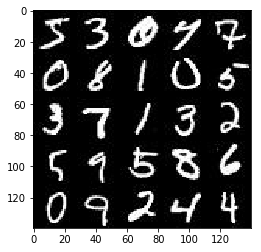

In [61]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

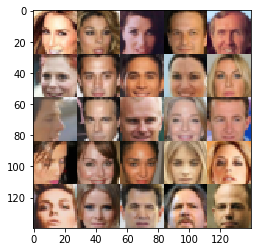

In [62]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [64]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [78]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # The kernel size is set to 5
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        x1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(x1 * alpha, x1) # 14x14x64
        x1 = tf.layers.dropout(inputs=relu1, rate=dropout, training=False)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2) # 7x7x128
        x2 = tf.layers.dropout(inputs=relu2, rate=dropout, training=False) 
            
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3) # 4x4x256
        
        #Flatten it
        # flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [79]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.8
    #Reuse the parameters when we are generating the samples but that will not be during the training
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())  
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(inputs=x2, rate=dropout, training=is_train)
        # 3x3x512 now        
                
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x2 = tf.layers.dropout(inputs=x2, rate=dropout, training=is_train)
        # 6x6x256 now

        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=2, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(inputs=x4, rate=dropout, training=is_train)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [80]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Label Smoothing method only on real data labels
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real)*(1 - smooth))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [81]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # Without tf.control_dependencies, TensorFlow’s batch normalization layer will not operate correctly during inference
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display. 4, 9, 16...other number will be round to squared numbers, I guess.
    :param input_z: Input Z Tensor. It appears here because the inner function "generator" needs it !!!!!
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [98]:
def plot_losses(losses):
    """
    Plot the discriminator and generator losses on the same graph
    :param d_loss: list of loss values for the discriminator
    :param g_loss: list of loss values for the generator
    """
    d_loss = [item[0] for item in losses]
    g_loss = [item[1] for item in losses]
    fig, ax = pyplot.subplots()
    pyplot.plot(d_loss, label='Discriminator', alpha=0.5)
    pyplot.plot(g_loss, label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

* First, load time for recording durations

In [71]:
import time

In [88]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], [] # samples is temporarily not used
    steps = 0 ## =batch_no
    print_every=10 ## =stats_every
    show_every=100
    n_images_to_show = 16    
    
    # Build Model, i.e., the tensorflow graph    
    # A graph defines the computation. It doesn’t compute anything, it doesn’t hold any values, it just defines the operations that you specified in your code.
    total_images_count , image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels) 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    total_batches = (total_images_count // batch_size) * epoch_count
    start_time = time.time()
    
    # Run session
    # A session allows to execute graphs or part of graphs. It allocates resources (on one or more machines) for that and holds the actual values of intermediate results and variables
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2 # Because the original Batch_images scale between -0.5 and 0.5, instead of -1 and 1
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers, the generator function will be called twice or thrice since the epoch is fixed to 2 in this project
                # Though this strategy seemed not to improve the image quality generated by the generator....
                # We need to set the input_real placeholder when we run the generator’s optimizer. The generator doesn’t actually use it, but we’d get an error without it because of the tf.control_dependencies block we created in model_opt function.
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate}) 
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # An alternative:
                # _ = sess.run([d_train_opt, g_train_opt, g_train_opt], feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:

                    current_time = time.time()
                    total_time = current_time - start_time
                    time_per_batch = total_time / steps
                    remaining_time = int(time_per_batch * (total_batches - steps))         
                                        
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))           
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "batch {}/{}...".format(steps, total_batches),
                          "time/batch...{:.2f}s".format(time_per_batch),
                          "remaining time...{}s".format(remaining_time),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images_to_show, input_z, image_channels, data_image_mode)

        # show the final output
        show_generator_output(sess, n_images_to_show, input_z, image_channels, data_image_mode)
        return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... batch 10/3750... time/batch...0.53s remaining time...1983s Discriminator Loss: 1.0752... Generator Loss: 4.4392
Epoch 1/2... batch 20/3750... time/batch...0.42s remaining time...1584s Discriminator Loss: 0.5796... Generator Loss: 2.2368
Epoch 1/2... batch 30/3750... time/batch...0.38s remaining time...1411s Discriminator Loss: 1.0352... Generator Loss: 6.0639
Epoch 1/2... batch 40/3750... time/batch...0.36s remaining time...1327s Discriminator Loss: 1.8499... Generator Loss: 0.6951
Epoch 1/2... batch 50/3750... time/batch...0.34s remaining time...1274s Discriminator Loss: 0.4559... Generator Loss: 3.3481
Epoch 1/2... batch 60/3750... time/batch...0.34s remaining time...1241s Discriminator Loss: 0.4478... Generator Loss: 3.0361
Epoch 1/2... batch 70/3750... time/batch...0.33s remaining time...1216s Discriminator Loss: 0.3679... Generator Loss: 5.1964
Epoch 1/2... batch 80/3750... time/batch...0.33s remaining time...1199s Discriminator Loss: 0.4111... Generator Loss: 3.4151


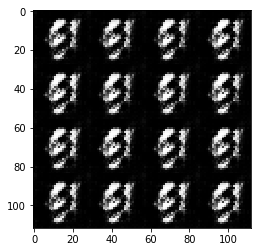

Epoch 1/2... batch 110/3750... time/batch...0.32s remaining time...1171s Discriminator Loss: 1.6407... Generator Loss: 0.5142
Epoch 1/2... batch 120/3750... time/batch...0.32s remaining time...1156s Discriminator Loss: 0.4540... Generator Loss: 3.8213
Epoch 1/2... batch 130/3750... time/batch...0.32s remaining time...1144s Discriminator Loss: 0.4634... Generator Loss: 3.1284
Epoch 1/2... batch 140/3750... time/batch...0.31s remaining time...1133s Discriminator Loss: 0.5819... Generator Loss: 2.8359
Epoch 1/2... batch 150/3750... time/batch...0.31s remaining time...1124s Discriminator Loss: 0.7079... Generator Loss: 9.3455
Epoch 1/2... batch 160/3750... time/batch...0.31s remaining time...1114s Discriminator Loss: 0.5193... Generator Loss: 2.5955
Epoch 1/2... batch 170/3750... time/batch...0.31s remaining time...1107s Discriminator Loss: 0.5027... Generator Loss: 2.6596
Epoch 1/2... batch 180/3750... time/batch...0.31s remaining time...1100s Discriminator Loss: 0.4011... Generator Loss:

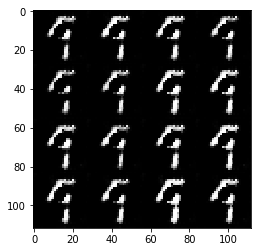

Epoch 1/2... batch 210/3750... time/batch...0.31s remaining time...1090s Discriminator Loss: 0.4891... Generator Loss: 2.6749
Epoch 1/2... batch 220/3750... time/batch...0.31s remaining time...1084s Discriminator Loss: 0.4251... Generator Loss: 7.2163
Epoch 1/2... batch 230/3750... time/batch...0.31s remaining time...1079s Discriminator Loss: 0.3783... Generator Loss: 3.9342
Epoch 1/2... batch 240/3750... time/batch...0.31s remaining time...1074s Discriminator Loss: 0.4434... Generator Loss: 2.8741
Epoch 1/2... batch 250/3750... time/batch...0.31s remaining time...1069s Discriminator Loss: 0.6423... Generator Loss: 1.9908
Epoch 1/2... batch 260/3750... time/batch...0.31s remaining time...1065s Discriminator Loss: 0.4478... Generator Loss: 3.7369
Epoch 1/2... batch 270/3750... time/batch...0.30s remaining time...1060s Discriminator Loss: 0.6031... Generator Loss: 2.6018
Epoch 1/2... batch 280/3750... time/batch...0.30s remaining time...1056s Discriminator Loss: 0.3882... Generator Loss:

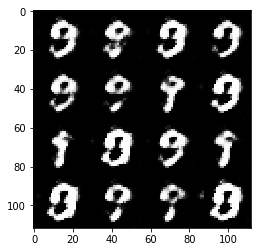

Epoch 1/2... batch 310/3750... time/batch...0.31s remaining time...1049s Discriminator Loss: 0.5167... Generator Loss: 2.4129
Epoch 1/2... batch 320/3750... time/batch...0.30s remaining time...1045s Discriminator Loss: 0.4408... Generator Loss: 3.8059
Epoch 1/2... batch 330/3750... time/batch...0.30s remaining time...1042s Discriminator Loss: 0.4857... Generator Loss: 3.4923
Epoch 1/2... batch 340/3750... time/batch...0.30s remaining time...1038s Discriminator Loss: 0.4395... Generator Loss: 2.4147
Epoch 1/2... batch 350/3750... time/batch...0.30s remaining time...1034s Discriminator Loss: 0.4870... Generator Loss: 2.4944
Epoch 1/2... batch 360/3750... time/batch...0.30s remaining time...1030s Discriminator Loss: 0.7865... Generator Loss: 1.6553
Epoch 1/2... batch 370/3750... time/batch...0.30s remaining time...1026s Discriminator Loss: 0.6544... Generator Loss: 1.6292
Epoch 1/2... batch 380/3750... time/batch...0.30s remaining time...1023s Discriminator Loss: 0.6339... Generator Loss:

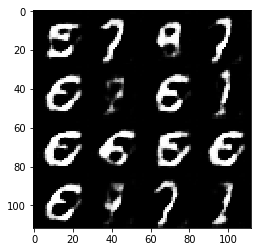

Epoch 1/2... batch 410/3750... time/batch...0.30s remaining time...1016s Discriminator Loss: 0.8581... Generator Loss: 1.4498
Epoch 1/2... batch 420/3750... time/batch...0.30s remaining time...1013s Discriminator Loss: 0.5119... Generator Loss: 2.7595
Epoch 1/2... batch 430/3750... time/batch...0.30s remaining time...1009s Discriminator Loss: 0.5038... Generator Loss: 2.7179
Epoch 1/2... batch 440/3750... time/batch...0.30s remaining time...1005s Discriminator Loss: 0.7013... Generator Loss: 1.6934
Epoch 1/2... batch 450/3750... time/batch...0.30s remaining time...1002s Discriminator Loss: 0.6672... Generator Loss: 2.0938
Epoch 1/2... batch 460/3750... time/batch...0.30s remaining time...998s Discriminator Loss: 0.5305... Generator Loss: 2.0740
Epoch 1/2... batch 470/3750... time/batch...0.30s remaining time...995s Discriminator Loss: 0.6818... Generator Loss: 1.9264
Epoch 1/2... batch 480/3750... time/batch...0.30s remaining time...991s Discriminator Loss: 0.5425... Generator Loss: 2.

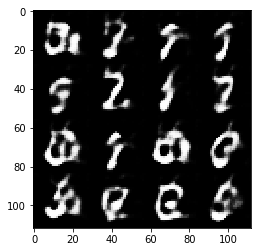

Epoch 1/2... batch 510/3750... time/batch...0.30s remaining time...986s Discriminator Loss: 0.5076... Generator Loss: 2.2372
Epoch 1/2... batch 520/3750... time/batch...0.30s remaining time...981s Discriminator Loss: 0.5006... Generator Loss: 2.7083
Epoch 1/2... batch 530/3750... time/batch...0.30s remaining time...977s Discriminator Loss: 0.7353... Generator Loss: 1.5677
Epoch 1/2... batch 540/3750... time/batch...0.30s remaining time...973s Discriminator Loss: 0.6751... Generator Loss: 2.2076
Epoch 1/2... batch 550/3750... time/batch...0.30s remaining time...969s Discriminator Loss: 0.5810... Generator Loss: 2.0067
Epoch 1/2... batch 560/3750... time/batch...0.30s remaining time...966s Discriminator Loss: 0.5847... Generator Loss: 2.7108
Epoch 1/2... batch 570/3750... time/batch...0.30s remaining time...962s Discriminator Loss: 0.5890... Generator Loss: 2.9656
Epoch 1/2... batch 580/3750... time/batch...0.30s remaining time...958s Discriminator Loss: 1.4979... Generator Loss: 0.7259


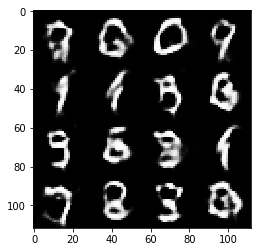

Epoch 1/2... batch 610/3750... time/batch...0.30s remaining time...949s Discriminator Loss: 0.7302... Generator Loss: 1.4524
Epoch 1/2... batch 620/3750... time/batch...0.30s remaining time...945s Discriminator Loss: 0.5244... Generator Loss: 2.0359
Epoch 1/2... batch 630/3750... time/batch...0.30s remaining time...941s Discriminator Loss: 0.8753... Generator Loss: 1.2317
Epoch 1/2... batch 640/3750... time/batch...0.30s remaining time...938s Discriminator Loss: 0.6095... Generator Loss: 2.3810
Epoch 1/2... batch 650/3750... time/batch...0.30s remaining time...935s Discriminator Loss: 0.6863... Generator Loss: 1.4986
Epoch 1/2... batch 660/3750... time/batch...0.30s remaining time...931s Discriminator Loss: 0.6655... Generator Loss: 1.7855
Epoch 1/2... batch 670/3750... time/batch...0.30s remaining time...928s Discriminator Loss: 0.5116... Generator Loss: 2.0026
Epoch 1/2... batch 680/3750... time/batch...0.30s remaining time...924s Discriminator Loss: 0.6726... Generator Loss: 1.5189


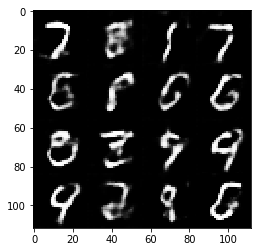

Epoch 1/2... batch 710/3750... time/batch...0.30s remaining time...916s Discriminator Loss: 0.7130... Generator Loss: 1.4410
Epoch 1/2... batch 720/3750... time/batch...0.30s remaining time...912s Discriminator Loss: 0.8106... Generator Loss: 1.1844
Epoch 1/2... batch 730/3750... time/batch...0.30s remaining time...909s Discriminator Loss: 0.4975... Generator Loss: 2.6459
Epoch 1/2... batch 740/3750... time/batch...0.30s remaining time...905s Discriminator Loss: 0.5116... Generator Loss: 2.4800
Epoch 1/2... batch 750/3750... time/batch...0.30s remaining time...902s Discriminator Loss: 0.5147... Generator Loss: 2.8289
Epoch 1/2... batch 760/3750... time/batch...0.30s remaining time...898s Discriminator Loss: 0.4263... Generator Loss: 3.1966
Epoch 1/2... batch 770/3750... time/batch...0.30s remaining time...895s Discriminator Loss: 0.6011... Generator Loss: 2.3110
Epoch 1/2... batch 780/3750... time/batch...0.30s remaining time...891s Discriminator Loss: 0.7038... Generator Loss: 3.0773


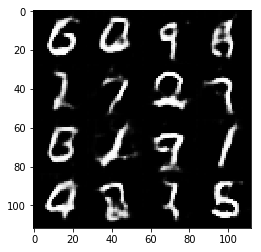

Epoch 1/2... batch 810/3750... time/batch...0.30s remaining time...883s Discriminator Loss: 0.4630... Generator Loss: 2.4466
Epoch 1/2... batch 820/3750... time/batch...0.30s remaining time...880s Discriminator Loss: 1.0325... Generator Loss: 1.4102
Epoch 1/2... batch 830/3750... time/batch...0.30s remaining time...876s Discriminator Loss: 0.8326... Generator Loss: 1.4665
Epoch 1/2... batch 840/3750... time/batch...0.30s remaining time...873s Discriminator Loss: 0.4887... Generator Loss: 3.2385
Epoch 1/2... batch 850/3750... time/batch...0.30s remaining time...870s Discriminator Loss: 0.4929... Generator Loss: 2.7176
Epoch 1/2... batch 860/3750... time/batch...0.30s remaining time...867s Discriminator Loss: 0.6369... Generator Loss: 2.0580
Epoch 1/2... batch 870/3750... time/batch...0.30s remaining time...863s Discriminator Loss: 0.7883... Generator Loss: 1.6212
Epoch 1/2... batch 880/3750... time/batch...0.30s remaining time...860s Discriminator Loss: 1.1056... Generator Loss: 1.0648


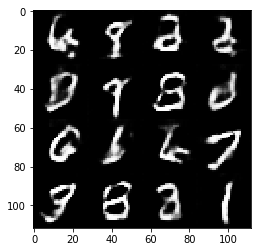

Epoch 1/2... batch 910/3750... time/batch...0.30s remaining time...852s Discriminator Loss: 0.6320... Generator Loss: 2.3528
Epoch 1/2... batch 920/3750... time/batch...0.30s remaining time...849s Discriminator Loss: 0.4435... Generator Loss: 2.5255
Epoch 1/2... batch 930/3750... time/batch...0.30s remaining time...846s Discriminator Loss: 1.0106... Generator Loss: 1.0681
Epoch 1/2... batch 940/3750... time/batch...0.30s remaining time...842s Discriminator Loss: 0.6300... Generator Loss: 2.1668
Epoch 1/2... batch 950/3750... time/batch...0.30s remaining time...839s Discriminator Loss: 0.5793... Generator Loss: 3.4643
Epoch 1/2... batch 960/3750... time/batch...0.30s remaining time...835s Discriminator Loss: 0.5963... Generator Loss: 2.1855
Epoch 1/2... batch 970/3750... time/batch...0.30s remaining time...832s Discriminator Loss: 0.6874... Generator Loss: 3.2272
Epoch 1/2... batch 980/3750... time/batch...0.30s remaining time...829s Discriminator Loss: 0.5372... Generator Loss: 2.5630


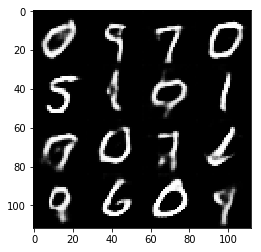

Epoch 1/2... batch 1010/3750... time/batch...0.30s remaining time...821s Discriminator Loss: 0.5238... Generator Loss: 2.6918
Epoch 1/2... batch 1020/3750... time/batch...0.30s remaining time...817s Discriminator Loss: 0.9048... Generator Loss: 1.2804
Epoch 1/2... batch 1030/3750... time/batch...0.30s remaining time...814s Discriminator Loss: 0.7983... Generator Loss: 1.8796
Epoch 1/2... batch 1040/3750... time/batch...0.30s remaining time...811s Discriminator Loss: 0.5357... Generator Loss: 2.5761
Epoch 1/2... batch 1050/3750... time/batch...0.30s remaining time...808s Discriminator Loss: 0.4905... Generator Loss: 2.4795
Epoch 1/2... batch 1060/3750... time/batch...0.30s remaining time...804s Discriminator Loss: 0.8154... Generator Loss: 1.6944
Epoch 1/2... batch 1070/3750... time/batch...0.30s remaining time...801s Discriminator Loss: 0.6518... Generator Loss: 2.5166
Epoch 1/2... batch 1080/3750... time/batch...0.30s remaining time...798s Discriminator Loss: 0.5054... Generator Loss:

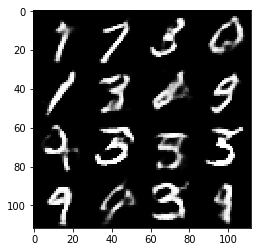

Epoch 1/2... batch 1110/3750... time/batch...0.30s remaining time...790s Discriminator Loss: 1.0894... Generator Loss: 0.8223
Epoch 1/2... batch 1120/3750... time/batch...0.30s remaining time...786s Discriminator Loss: 0.4807... Generator Loss: 3.3282
Epoch 1/2... batch 1130/3750... time/batch...0.30s remaining time...783s Discriminator Loss: 0.5686... Generator Loss: 2.1728
Epoch 1/2... batch 1140/3750... time/batch...0.30s remaining time...780s Discriminator Loss: 0.5655... Generator Loss: 1.5281
Epoch 1/2... batch 1150/3750... time/batch...0.30s remaining time...776s Discriminator Loss: 1.0491... Generator Loss: 1.0874
Epoch 1/2... batch 1160/3750... time/batch...0.30s remaining time...773s Discriminator Loss: 0.4167... Generator Loss: 3.0516
Epoch 1/2... batch 1170/3750... time/batch...0.30s remaining time...770s Discriminator Loss: 0.7617... Generator Loss: 1.8631
Epoch 1/2... batch 1180/3750... time/batch...0.30s remaining time...767s Discriminator Loss: 0.4623... Generator Loss:

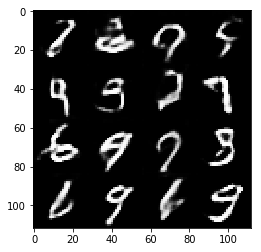

Epoch 1/2... batch 1210/3750... time/batch...0.30s remaining time...758s Discriminator Loss: 0.4133... Generator Loss: 3.1954
Epoch 1/2... batch 1220/3750... time/batch...0.30s remaining time...755s Discriminator Loss: 0.5256... Generator Loss: 1.9802
Epoch 1/2... batch 1230/3750... time/batch...0.30s remaining time...751s Discriminator Loss: 0.4879... Generator Loss: 3.5586
Epoch 1/2... batch 1240/3750... time/batch...0.30s remaining time...748s Discriminator Loss: 0.5637... Generator Loss: 2.4525
Epoch 1/2... batch 1250/3750... time/batch...0.30s remaining time...745s Discriminator Loss: 0.4686... Generator Loss: 3.0410
Epoch 1/2... batch 1260/3750... time/batch...0.30s remaining time...742s Discriminator Loss: 0.5706... Generator Loss: 2.9609
Epoch 1/2... batch 1270/3750... time/batch...0.30s remaining time...739s Discriminator Loss: 1.0266... Generator Loss: 1.1094
Epoch 1/2... batch 1280/3750... time/batch...0.30s remaining time...736s Discriminator Loss: 0.4598... Generator Loss:

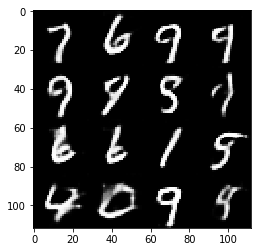

Epoch 1/2... batch 1310/3750... time/batch...0.30s remaining time...727s Discriminator Loss: 0.4841... Generator Loss: 2.8940
Epoch 1/2... batch 1320/3750... time/batch...0.30s remaining time...724s Discriminator Loss: 0.8003... Generator Loss: 2.1566
Epoch 1/2... batch 1330/3750... time/batch...0.30s remaining time...721s Discriminator Loss: 1.3773... Generator Loss: 0.8731
Epoch 1/2... batch 1340/3750... time/batch...0.30s remaining time...718s Discriminator Loss: 0.9589... Generator Loss: 4.9033
Epoch 1/2... batch 1350/3750... time/batch...0.30s remaining time...714s Discriminator Loss: 0.9303... Generator Loss: 1.7140
Epoch 1/2... batch 1360/3750... time/batch...0.30s remaining time...711s Discriminator Loss: 0.8683... Generator Loss: 1.4931
Epoch 1/2... batch 1370/3750... time/batch...0.30s remaining time...708s Discriminator Loss: 0.6944... Generator Loss: 1.5630
Epoch 1/2... batch 1380/3750... time/batch...0.30s remaining time...705s Discriminator Loss: 0.5219... Generator Loss:

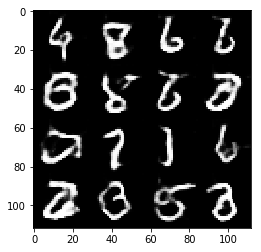

Epoch 1/2... batch 1410/3750... time/batch...0.30s remaining time...697s Discriminator Loss: 0.5506... Generator Loss: 3.1372
Epoch 1/2... batch 1420/3750... time/batch...0.30s remaining time...694s Discriminator Loss: 0.5548... Generator Loss: 1.6454
Epoch 1/2... batch 1430/3750... time/batch...0.30s remaining time...691s Discriminator Loss: 1.9245... Generator Loss: 5.8636
Epoch 1/2... batch 1440/3750... time/batch...0.30s remaining time...687s Discriminator Loss: 0.5588... Generator Loss: 2.3576
Epoch 1/2... batch 1450/3750... time/batch...0.30s remaining time...684s Discriminator Loss: 0.4127... Generator Loss: 3.0582
Epoch 1/2... batch 1460/3750... time/batch...0.30s remaining time...681s Discriminator Loss: 0.7580... Generator Loss: 1.2838
Epoch 1/2... batch 1470/3750... time/batch...0.30s remaining time...678s Discriminator Loss: 0.8580... Generator Loss: 1.4313
Epoch 1/2... batch 1480/3750... time/batch...0.30s remaining time...675s Discriminator Loss: 0.4428... Generator Loss:

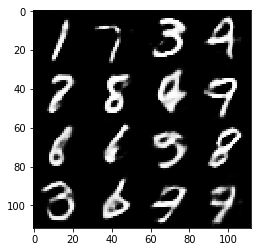

Epoch 1/2... batch 1510/3750... time/batch...0.30s remaining time...667s Discriminator Loss: 0.7367... Generator Loss: 2.0128
Epoch 1/2... batch 1520/3750... time/batch...0.30s remaining time...664s Discriminator Loss: 0.4947... Generator Loss: 2.6200
Epoch 1/2... batch 1530/3750... time/batch...0.30s remaining time...661s Discriminator Loss: 0.5466... Generator Loss: 2.7061
Epoch 1/2... batch 1540/3750... time/batch...0.30s remaining time...658s Discriminator Loss: 0.4170... Generator Loss: 2.7712
Epoch 1/2... batch 1550/3750... time/batch...0.30s remaining time...655s Discriminator Loss: 0.6648... Generator Loss: 2.4060
Epoch 1/2... batch 1560/3750... time/batch...0.30s remaining time...652s Discriminator Loss: 0.5832... Generator Loss: 2.0704
Epoch 1/2... batch 1570/3750... time/batch...0.30s remaining time...649s Discriminator Loss: 0.4845... Generator Loss: 3.2302
Epoch 1/2... batch 1580/3750... time/batch...0.30s remaining time...646s Discriminator Loss: 0.4725... Generator Loss:

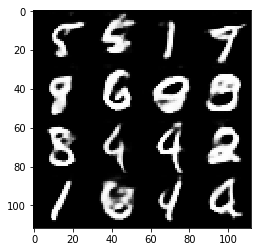

Epoch 1/2... batch 1610/3750... time/batch...0.30s remaining time...638s Discriminator Loss: 0.5075... Generator Loss: 2.0482
Epoch 1/2... batch 1620/3750... time/batch...0.30s remaining time...635s Discriminator Loss: 0.5809... Generator Loss: 2.3222
Epoch 1/2... batch 1630/3750... time/batch...0.30s remaining time...632s Discriminator Loss: 0.6075... Generator Loss: 3.7252
Epoch 1/2... batch 1640/3750... time/batch...0.30s remaining time...628s Discriminator Loss: 0.3832... Generator Loss: 3.2727
Epoch 1/2... batch 1650/3750... time/batch...0.30s remaining time...625s Discriminator Loss: 0.4364... Generator Loss: 3.5192
Epoch 1/2... batch 1660/3750... time/batch...0.30s remaining time...622s Discriminator Loss: 0.5318... Generator Loss: 2.9595
Epoch 1/2... batch 1670/3750... time/batch...0.30s remaining time...619s Discriminator Loss: 0.5977... Generator Loss: 2.2507
Epoch 1/2... batch 1680/3750... time/batch...0.30s remaining time...616s Discriminator Loss: 0.4243... Generator Loss:

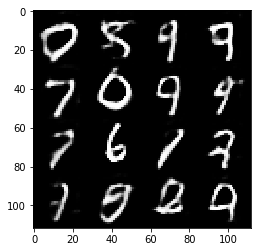

Epoch 1/2... batch 1710/3750... time/batch...0.30s remaining time...608s Discriminator Loss: 0.3765... Generator Loss: 2.6142
Epoch 1/2... batch 1720/3750... time/batch...0.30s remaining time...605s Discriminator Loss: 2.2659... Generator Loss: 0.7894
Epoch 1/2... batch 1730/3750... time/batch...0.30s remaining time...602s Discriminator Loss: 0.8411... Generator Loss: 1.6492
Epoch 1/2... batch 1740/3750... time/batch...0.30s remaining time...598s Discriminator Loss: 0.6219... Generator Loss: 1.8432
Epoch 1/2... batch 1750/3750... time/batch...0.30s remaining time...595s Discriminator Loss: 0.4862... Generator Loss: 1.8291
Epoch 1/2... batch 1760/3750... time/batch...0.30s remaining time...592s Discriminator Loss: 0.4341... Generator Loss: 3.1348
Epoch 1/2... batch 1770/3750... time/batch...0.30s remaining time...589s Discriminator Loss: 0.4340... Generator Loss: 2.7490
Epoch 1/2... batch 1780/3750... time/batch...0.30s remaining time...586s Discriminator Loss: 0.4052... Generator Loss:

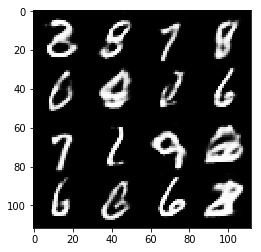

Epoch 1/2... batch 1810/3750... time/batch...0.30s remaining time...577s Discriminator Loss: 0.4634... Generator Loss: 3.0648
Epoch 1/2... batch 1820/3750... time/batch...0.30s remaining time...574s Discriminator Loss: 0.3865... Generator Loss: 4.0661
Epoch 1/2... batch 1830/3750... time/batch...0.30s remaining time...571s Discriminator Loss: 0.4811... Generator Loss: 2.4914
Epoch 1/2... batch 1840/3750... time/batch...0.30s remaining time...568s Discriminator Loss: 0.3879... Generator Loss: 3.4611
Epoch 1/2... batch 1850/3750... time/batch...0.30s remaining time...565s Discriminator Loss: 0.5174... Generator Loss: 1.7171
Epoch 1/2... batch 1860/3750... time/batch...0.30s remaining time...562s Discriminator Loss: 0.5876... Generator Loss: 2.0401
Epoch 1/2... batch 1870/3750... time/batch...0.30s remaining time...559s Discriminator Loss: 0.3658... Generator Loss: 4.9084
Epoch 2/2... batch 1880/3750... time/batch...0.30s remaining time...556s Discriminator Loss: 0.4433... Generator Loss:

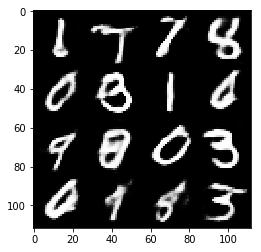

Epoch 2/2... batch 1910/3750... time/batch...0.30s remaining time...547s Discriminator Loss: 0.4045... Generator Loss: 3.6804
Epoch 2/2... batch 1920/3750... time/batch...0.30s remaining time...544s Discriminator Loss: 0.5215... Generator Loss: 2.2929
Epoch 2/2... batch 1930/3750... time/batch...0.30s remaining time...541s Discriminator Loss: 0.5302... Generator Loss: 2.0643
Epoch 2/2... batch 1940/3750... time/batch...0.30s remaining time...538s Discriminator Loss: 0.3954... Generator Loss: 3.6060
Epoch 2/2... batch 1950/3750... time/batch...0.30s remaining time...535s Discriminator Loss: 0.3832... Generator Loss: 3.7360
Epoch 2/2... batch 1960/3750... time/batch...0.30s remaining time...532s Discriminator Loss: 0.4964... Generator Loss: 3.0990
Epoch 2/2... batch 1970/3750... time/batch...0.30s remaining time...529s Discriminator Loss: 0.5020... Generator Loss: 2.4407
Epoch 2/2... batch 1980/3750... time/batch...0.30s remaining time...526s Discriminator Loss: 0.6612... Generator Loss:

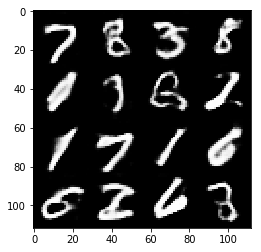

Epoch 2/2... batch 2010/3750... time/batch...0.30s remaining time...517s Discriminator Loss: 0.3799... Generator Loss: 4.0030
Epoch 2/2... batch 2020/3750... time/batch...0.30s remaining time...514s Discriminator Loss: 0.4035... Generator Loss: 2.9659
Epoch 2/2... batch 2030/3750... time/batch...0.30s remaining time...511s Discriminator Loss: 0.5068... Generator Loss: 2.0850
Epoch 2/2... batch 2040/3750... time/batch...0.30s remaining time...508s Discriminator Loss: 0.3811... Generator Loss: 3.0831
Epoch 2/2... batch 2050/3750... time/batch...0.30s remaining time...505s Discriminator Loss: 0.3593... Generator Loss: 3.6639
Epoch 2/2... batch 2060/3750... time/batch...0.30s remaining time...502s Discriminator Loss: 0.3765... Generator Loss: 4.4245
Epoch 2/2... batch 2070/3750... time/batch...0.30s remaining time...499s Discriminator Loss: 0.4011... Generator Loss: 3.3569
Epoch 2/2... batch 2080/3750... time/batch...0.30s remaining time...496s Discriminator Loss: 0.4600... Generator Loss:

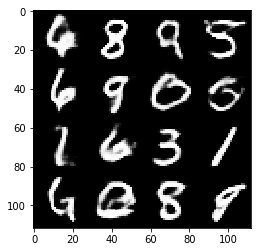

Epoch 2/2... batch 2110/3750... time/batch...0.30s remaining time...488s Discriminator Loss: 0.5350... Generator Loss: 2.7230
Epoch 2/2... batch 2120/3750... time/batch...0.30s remaining time...485s Discriminator Loss: 0.5349... Generator Loss: 3.8778
Epoch 2/2... batch 2130/3750... time/batch...0.30s remaining time...481s Discriminator Loss: 0.3957... Generator Loss: 3.2417
Epoch 2/2... batch 2140/3750... time/batch...0.30s remaining time...478s Discriminator Loss: 0.4182... Generator Loss: 2.6247
Epoch 2/2... batch 2150/3750... time/batch...0.30s remaining time...475s Discriminator Loss: 0.4697... Generator Loss: 2.6966
Epoch 2/2... batch 2160/3750... time/batch...0.30s remaining time...472s Discriminator Loss: 0.3651... Generator Loss: 3.0525
Epoch 2/2... batch 2170/3750... time/batch...0.30s remaining time...469s Discriminator Loss: 0.7025... Generator Loss: 1.9152
Epoch 2/2... batch 2180/3750... time/batch...0.30s remaining time...466s Discriminator Loss: 0.3675... Generator Loss:

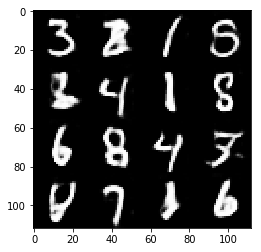

Epoch 2/2... batch 2210/3750... time/batch...0.30s remaining time...458s Discriminator Loss: 0.4652... Generator Loss: 4.3147
Epoch 2/2... batch 2220/3750... time/batch...0.30s remaining time...454s Discriminator Loss: 0.4414... Generator Loss: 2.5375
Epoch 2/2... batch 2230/3750... time/batch...0.30s remaining time...451s Discriminator Loss: 0.4562... Generator Loss: 4.7003
Epoch 2/2... batch 2240/3750... time/batch...0.30s remaining time...448s Discriminator Loss: 0.4002... Generator Loss: 3.9679
Epoch 2/2... batch 2250/3750... time/batch...0.30s remaining time...445s Discriminator Loss: 0.3553... Generator Loss: 3.9525
Epoch 2/2... batch 2260/3750... time/batch...0.30s remaining time...442s Discriminator Loss: 0.3814... Generator Loss: 2.7212
Epoch 2/2... batch 2270/3750... time/batch...0.30s remaining time...439s Discriminator Loss: 0.4287... Generator Loss: 3.8312
Epoch 2/2... batch 2280/3750... time/batch...0.30s remaining time...436s Discriminator Loss: 0.3792... Generator Loss:

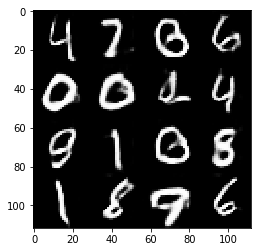

Epoch 2/2... batch 2310/3750... time/batch...0.30s remaining time...428s Discriminator Loss: 0.4500... Generator Loss: 3.4708
Epoch 2/2... batch 2320/3750... time/batch...0.30s remaining time...425s Discriminator Loss: 0.6417... Generator Loss: 2.4254
Epoch 2/2... batch 2330/3750... time/batch...0.30s remaining time...422s Discriminator Loss: 0.3904... Generator Loss: 3.3939
Epoch 2/2... batch 2340/3750... time/batch...0.30s remaining time...419s Discriminator Loss: 0.4312... Generator Loss: 3.3118
Epoch 2/2... batch 2350/3750... time/batch...0.30s remaining time...416s Discriminator Loss: 0.3618... Generator Loss: 3.5265
Epoch 2/2... batch 2360/3750... time/batch...0.30s remaining time...413s Discriminator Loss: 0.4104... Generator Loss: 4.1159
Epoch 2/2... batch 2370/3750... time/batch...0.30s remaining time...410s Discriminator Loss: 0.3789... Generator Loss: 3.2447
Epoch 2/2... batch 2380/3750... time/batch...0.30s remaining time...407s Discriminator Loss: 1.4566... Generator Loss:

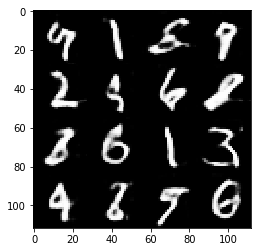

Epoch 2/2... batch 2410/3750... time/batch...0.30s remaining time...398s Discriminator Loss: 0.5166... Generator Loss: 3.6284
Epoch 2/2... batch 2420/3750... time/batch...0.30s remaining time...395s Discriminator Loss: 0.4024... Generator Loss: 4.8475
Epoch 2/2... batch 2430/3750... time/batch...0.30s remaining time...392s Discriminator Loss: 0.4359... Generator Loss: 4.7850
Epoch 2/2... batch 2440/3750... time/batch...0.30s remaining time...389s Discriminator Loss: 0.3599... Generator Loss: 3.9246
Epoch 2/2... batch 2450/3750... time/batch...0.30s remaining time...386s Discriminator Loss: 0.3836... Generator Loss: 3.2433
Epoch 2/2... batch 2460/3750... time/batch...0.30s remaining time...383s Discriminator Loss: 0.4162... Generator Loss: 2.8982
Epoch 2/2... batch 2470/3750... time/batch...0.30s remaining time...380s Discriminator Loss: 0.6540... Generator Loss: 2.0465
Epoch 2/2... batch 2480/3750... time/batch...0.30s remaining time...377s Discriminator Loss: 0.3989... Generator Loss:

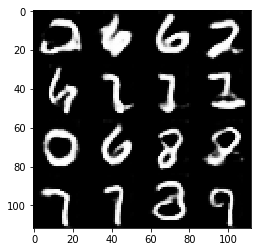

Epoch 2/2... batch 2510/3750... time/batch...0.30s remaining time...368s Discriminator Loss: 0.7039... Generator Loss: 2.1695
Epoch 2/2... batch 2520/3750... time/batch...0.30s remaining time...365s Discriminator Loss: 0.3989... Generator Loss: 3.1994
Epoch 2/2... batch 2530/3750... time/batch...0.30s remaining time...362s Discriminator Loss: 0.3765... Generator Loss: 4.1023
Epoch 2/2... batch 2540/3750... time/batch...0.30s remaining time...359s Discriminator Loss: 0.3823... Generator Loss: 3.1176
Epoch 2/2... batch 2550/3750... time/batch...0.30s remaining time...356s Discriminator Loss: 0.4769... Generator Loss: 2.6925
Epoch 2/2... batch 2560/3750... time/batch...0.30s remaining time...353s Discriminator Loss: 0.4471... Generator Loss: 4.1514
Epoch 2/2... batch 2570/3750... time/batch...0.30s remaining time...350s Discriminator Loss: 0.4080... Generator Loss: 3.8902
Epoch 2/2... batch 2580/3750... time/batch...0.30s remaining time...347s Discriminator Loss: 0.4324... Generator Loss:

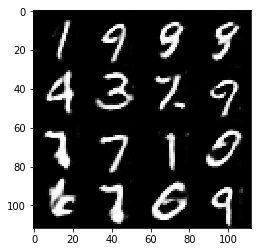

Epoch 2/2... batch 2610/3750... time/batch...0.30s remaining time...338s Discriminator Loss: 0.3745... Generator Loss: 3.0120
Epoch 2/2... batch 2620/3750... time/batch...0.30s remaining time...335s Discriminator Loss: 0.3577... Generator Loss: 4.2445
Epoch 2/2... batch 2630/3750... time/batch...0.30s remaining time...332s Discriminator Loss: 0.3570... Generator Loss: 4.2482
Epoch 2/2... batch 2640/3750... time/batch...0.30s remaining time...329s Discriminator Loss: 0.5842... Generator Loss: 2.8990
Epoch 2/2... batch 2650/3750... time/batch...0.30s remaining time...326s Discriminator Loss: 0.5090... Generator Loss: 1.9467
Epoch 2/2... batch 2660/3750... time/batch...0.30s remaining time...323s Discriminator Loss: 0.3612... Generator Loss: 4.3950
Epoch 2/2... batch 2670/3750... time/batch...0.30s remaining time...320s Discriminator Loss: 0.4062... Generator Loss: 4.6178
Epoch 2/2... batch 2680/3750... time/batch...0.30s remaining time...317s Discriminator Loss: 0.4052... Generator Loss:

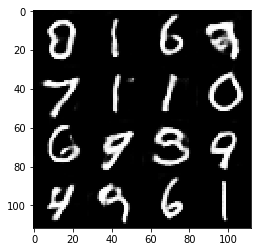

Epoch 2/2... batch 2710/3750... time/batch...0.30s remaining time...308s Discriminator Loss: 0.3544... Generator Loss: 4.1907
Epoch 2/2... batch 2720/3750... time/batch...0.30s remaining time...305s Discriminator Loss: 0.4531... Generator Loss: 2.7579
Epoch 2/2... batch 2730/3750... time/batch...0.30s remaining time...302s Discriminator Loss: 0.3759... Generator Loss: 4.6953
Epoch 2/2... batch 2740/3750... time/batch...0.30s remaining time...299s Discriminator Loss: 0.3704... Generator Loss: 3.9947
Epoch 2/2... batch 2750/3750... time/batch...0.30s remaining time...296s Discriminator Loss: 0.3605... Generator Loss: 3.9268
Epoch 2/2... batch 2760/3750... time/batch...0.30s remaining time...293s Discriminator Loss: 0.3563... Generator Loss: 3.9048
Epoch 2/2... batch 2770/3750... time/batch...0.30s remaining time...290s Discriminator Loss: 0.7293... Generator Loss: 2.0425
Epoch 2/2... batch 2780/3750... time/batch...0.30s remaining time...287s Discriminator Loss: 0.3647... Generator Loss:

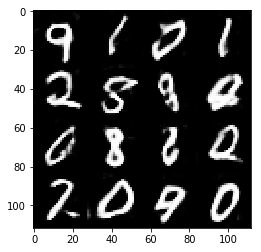

Epoch 2/2... batch 2810/3750... time/batch...0.30s remaining time...278s Discriminator Loss: 0.3953... Generator Loss: 3.4738
Epoch 2/2... batch 2820/3750... time/batch...0.30s remaining time...275s Discriminator Loss: 0.4630... Generator Loss: 2.8992
Epoch 2/2... batch 2830/3750... time/batch...0.30s remaining time...272s Discriminator Loss: 0.4055... Generator Loss: 4.3667
Epoch 2/2... batch 2840/3750... time/batch...0.30s remaining time...270s Discriminator Loss: 0.5036... Generator Loss: 3.1207
Epoch 2/2... batch 2850/3750... time/batch...0.30s remaining time...267s Discriminator Loss: 0.3936... Generator Loss: 3.3156
Epoch 2/2... batch 2860/3750... time/batch...0.30s remaining time...264s Discriminator Loss: 0.4645... Generator Loss: 3.8527
Epoch 2/2... batch 2870/3750... time/batch...0.30s remaining time...261s Discriminator Loss: 1.7004... Generator Loss: 7.1158
Epoch 2/2... batch 2880/3750... time/batch...0.30s remaining time...258s Discriminator Loss: 0.3959... Generator Loss:

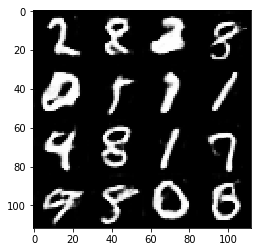

Epoch 2/2... batch 2910/3750... time/batch...0.30s remaining time...249s Discriminator Loss: 0.3626... Generator Loss: 4.9305
Epoch 2/2... batch 2920/3750... time/batch...0.30s remaining time...246s Discriminator Loss: 0.5326... Generator Loss: 2.8955
Epoch 2/2... batch 2930/3750... time/batch...0.30s remaining time...243s Discriminator Loss: 0.3664... Generator Loss: 4.5691
Epoch 2/2... batch 2940/3750... time/batch...0.30s remaining time...240s Discriminator Loss: 0.8501... Generator Loss: 1.6294
Epoch 2/2... batch 2950/3750... time/batch...0.30s remaining time...237s Discriminator Loss: 0.4525... Generator Loss: 2.5320
Epoch 2/2... batch 2960/3750... time/batch...0.30s remaining time...234s Discriminator Loss: 0.3513... Generator Loss: 3.9560
Epoch 2/2... batch 2970/3750... time/batch...0.30s remaining time...231s Discriminator Loss: 0.3696... Generator Loss: 3.2185
Epoch 2/2... batch 2980/3750... time/batch...0.30s remaining time...228s Discriminator Loss: 0.3596... Generator Loss:

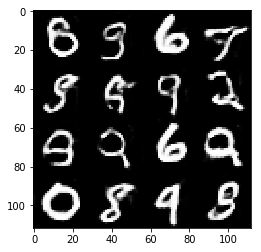

Epoch 2/2... batch 3010/3750... time/batch...0.30s remaining time...219s Discriminator Loss: 0.8073... Generator Loss: 1.9518
Epoch 2/2... batch 3020/3750... time/batch...0.30s remaining time...216s Discriminator Loss: 0.3653... Generator Loss: 4.1819
Epoch 2/2... batch 3030/3750... time/batch...0.30s remaining time...213s Discriminator Loss: 0.3609... Generator Loss: 4.2008
Epoch 2/2... batch 3040/3750... time/batch...0.30s remaining time...210s Discriminator Loss: 0.3454... Generator Loss: 4.9529
Epoch 2/2... batch 3050/3750... time/batch...0.30s remaining time...207s Discriminator Loss: 0.3606... Generator Loss: 3.7005
Epoch 2/2... batch 3060/3750... time/batch...0.30s remaining time...204s Discriminator Loss: 0.4019... Generator Loss: 4.0543
Epoch 2/2... batch 3070/3750... time/batch...0.30s remaining time...201s Discriminator Loss: 0.3372... Generator Loss: 5.2470
Epoch 2/2... batch 3080/3750... time/batch...0.30s remaining time...198s Discriminator Loss: 0.3678... Generator Loss:

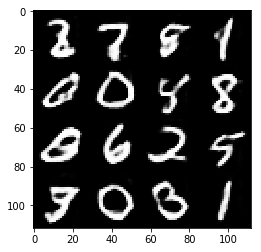

Epoch 2/2... batch 3110/3750... time/batch...0.30s remaining time...190s Discriminator Loss: 0.3545... Generator Loss: 4.1744
Epoch 2/2... batch 3120/3750... time/batch...0.30s remaining time...187s Discriminator Loss: 0.3616... Generator Loss: 4.1307
Epoch 2/2... batch 3130/3750... time/batch...0.30s remaining time...184s Discriminator Loss: 1.2400... Generator Loss: 6.9412
Epoch 2/2... batch 3140/3750... time/batch...0.30s remaining time...181s Discriminator Loss: 0.3730... Generator Loss: 3.5062
Epoch 2/2... batch 3150/3750... time/batch...0.30s remaining time...178s Discriminator Loss: 0.3702... Generator Loss: 4.3813
Epoch 2/2... batch 3160/3750... time/batch...0.30s remaining time...175s Discriminator Loss: 0.3625... Generator Loss: 4.0969
Epoch 2/2... batch 3170/3750... time/batch...0.30s remaining time...172s Discriminator Loss: 0.3763... Generator Loss: 3.2985
Epoch 2/2... batch 3180/3750... time/batch...0.30s remaining time...169s Discriminator Loss: 0.4141... Generator Loss:

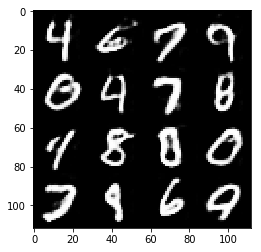

Epoch 2/2... batch 3210/3750... time/batch...0.30s remaining time...160s Discriminator Loss: 0.6908... Generator Loss: 5.3124
Epoch 2/2... batch 3220/3750... time/batch...0.30s remaining time...157s Discriminator Loss: 0.6274... Generator Loss: 1.3565
Epoch 2/2... batch 3230/3750... time/batch...0.30s remaining time...154s Discriminator Loss: 0.4407... Generator Loss: 2.8533
Epoch 2/2... batch 3240/3750... time/batch...0.30s remaining time...151s Discriminator Loss: 0.3852... Generator Loss: 3.9361
Epoch 2/2... batch 3250/3750... time/batch...0.30s remaining time...148s Discriminator Loss: 0.3998... Generator Loss: 2.8387
Epoch 2/2... batch 3260/3750... time/batch...0.30s remaining time...145s Discriminator Loss: 0.3795... Generator Loss: 4.9337
Epoch 2/2... batch 3270/3750... time/batch...0.30s remaining time...142s Discriminator Loss: 0.3735... Generator Loss: 4.1123
Epoch 2/2... batch 3280/3750... time/batch...0.30s remaining time...139s Discriminator Loss: 0.4296... Generator Loss:

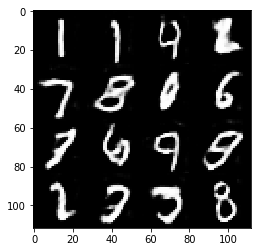

Epoch 2/2... batch 3310/3750... time/batch...0.30s remaining time...130s Discriminator Loss: 0.3466... Generator Loss: 4.0608
Epoch 2/2... batch 3320/3750... time/batch...0.30s remaining time...127s Discriminator Loss: 0.3557... Generator Loss: 3.7923
Epoch 2/2... batch 3330/3750... time/batch...0.30s remaining time...124s Discriminator Loss: 0.4074... Generator Loss: 3.1996
Epoch 2/2... batch 3340/3750... time/batch...0.30s remaining time...121s Discriminator Loss: 0.3697... Generator Loss: 4.4183
Epoch 2/2... batch 3350/3750... time/batch...0.30s remaining time...118s Discriminator Loss: 0.3780... Generator Loss: 3.3480
Epoch 2/2... batch 3360/3750... time/batch...0.30s remaining time...115s Discriminator Loss: 0.3654... Generator Loss: 4.3242
Epoch 2/2... batch 3370/3750... time/batch...0.30s remaining time...112s Discriminator Loss: 0.3835... Generator Loss: 4.2413
Epoch 2/2... batch 3380/3750... time/batch...0.30s remaining time...109s Discriminator Loss: 0.4548... Generator Loss:

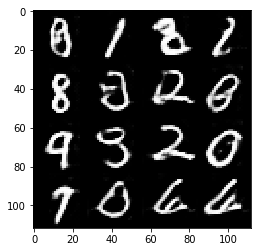

Epoch 2/2... batch 3410/3750... time/batch...0.30s remaining time...100s Discriminator Loss: 0.3882... Generator Loss: 2.9800
Epoch 2/2... batch 3420/3750... time/batch...0.30s remaining time...98s Discriminator Loss: 0.3959... Generator Loss: 4.9414
Epoch 2/2... batch 3430/3750... time/batch...0.30s remaining time...95s Discriminator Loss: 0.3421... Generator Loss: 4.9801
Epoch 2/2... batch 3440/3750... time/batch...0.30s remaining time...92s Discriminator Loss: 0.3573... Generator Loss: 3.7998
Epoch 2/2... batch 3450/3750... time/batch...0.30s remaining time...89s Discriminator Loss: 0.6130... Generator Loss: 3.0016
Epoch 2/2... batch 3460/3750... time/batch...0.30s remaining time...86s Discriminator Loss: 0.4130... Generator Loss: 3.3766
Epoch 2/2... batch 3470/3750... time/batch...0.30s remaining time...83s Discriminator Loss: 0.3561... Generator Loss: 4.2435
Epoch 2/2... batch 3480/3750... time/batch...0.30s remaining time...80s Discriminator Loss: 0.3523... Generator Loss: 3.9478

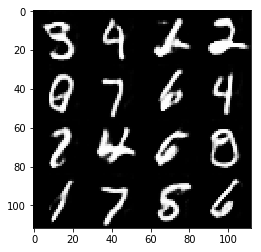

Epoch 2/2... batch 3510/3750... time/batch...0.30s remaining time...71s Discriminator Loss: 0.3888... Generator Loss: 3.5494
Epoch 2/2... batch 3520/3750... time/batch...0.30s remaining time...68s Discriminator Loss: 0.5107... Generator Loss: 2.9862
Epoch 2/2... batch 3530/3750... time/batch...0.30s remaining time...65s Discriminator Loss: 0.3405... Generator Loss: 3.6695
Epoch 2/2... batch 3540/3750... time/batch...0.30s remaining time...62s Discriminator Loss: 0.3593... Generator Loss: 4.6231
Epoch 2/2... batch 3550/3750... time/batch...0.30s remaining time...59s Discriminator Loss: 0.4034... Generator Loss: 4.3337
Epoch 2/2... batch 3560/3750... time/batch...0.30s remaining time...56s Discriminator Loss: 0.3523... Generator Loss: 3.2815
Epoch 2/2... batch 3570/3750... time/batch...0.30s remaining time...53s Discriminator Loss: 0.4257... Generator Loss: 4.0227
Epoch 2/2... batch 3580/3750... time/batch...0.30s remaining time...50s Discriminator Loss: 0.4220... Generator Loss: 2.6696


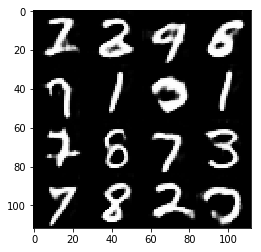

Epoch 2/2... batch 3610/3750... time/batch...0.30s remaining time...41s Discriminator Loss: 0.5088... Generator Loss: 3.1858
Epoch 2/2... batch 3620/3750... time/batch...0.30s remaining time...38s Discriminator Loss: 0.5178... Generator Loss: 2.6489
Epoch 2/2... batch 3630/3750... time/batch...0.30s remaining time...35s Discriminator Loss: 0.4349... Generator Loss: 3.0596
Epoch 2/2... batch 3640/3750... time/batch...0.30s remaining time...32s Discriminator Loss: 0.4579... Generator Loss: 2.8606
Epoch 2/2... batch 3650/3750... time/batch...0.30s remaining time...29s Discriminator Loss: 0.4011... Generator Loss: 3.5398
Epoch 2/2... batch 3660/3750... time/batch...0.30s remaining time...26s Discriminator Loss: 0.3609... Generator Loss: 3.6076
Epoch 2/2... batch 3670/3750... time/batch...0.30s remaining time...23s Discriminator Loss: 0.3801... Generator Loss: 2.7155
Epoch 2/2... batch 3680/3750... time/batch...0.30s remaining time...20s Discriminator Loss: 0.4019... Generator Loss: 2.6794


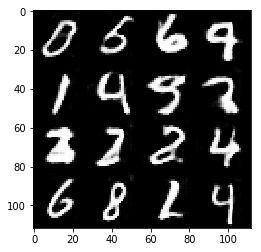

Epoch 2/2... batch 3710/3750... time/batch...0.30s remaining time...11s Discriminator Loss: 0.4043... Generator Loss: 6.1777
Epoch 2/2... batch 3720/3750... time/batch...0.30s remaining time...8s Discriminator Loss: 0.3853... Generator Loss: 3.3544
Epoch 2/2... batch 3730/3750... time/batch...0.30s remaining time...5s Discriminator Loss: 0.3466... Generator Loss: 4.3954
Epoch 2/2... batch 3740/3750... time/batch...0.30s remaining time...2s Discriminator Loss: 0.3724... Generator Loss: 3.8462
Epoch 2/2... batch 3750/3750... time/batch...0.30s remaining time...0s Discriminator Loss: 0.3501... Generator Loss: 4.2606


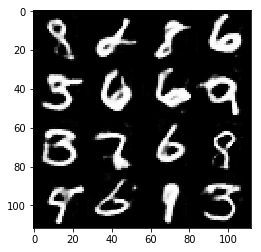

In [100]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, _ = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

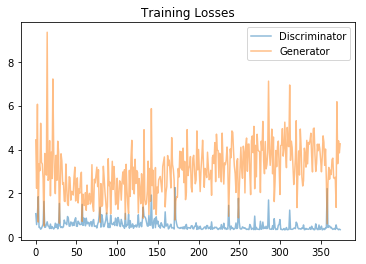

In [101]:
plot_losses(losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... batch 10/6331... time/batch...0.56s remaining time...3516s Discriminator Loss: 0.4450... Generator Loss: 2.6662
Epoch 1/1... batch 20/6331... time/batch...0.45s remaining time...2833s Discriminator Loss: 0.4753... Generator Loss: 3.1687
Epoch 1/1... batch 30/6331... time/batch...0.40s remaining time...2545s Discriminator Loss: 0.4064... Generator Loss: 3.5728
Epoch 1/1... batch 40/6331... time/batch...0.38s remaining time...2402s Discriminator Loss: 0.4184... Generator Loss: 3.4162
Epoch 1/1... batch 50/6331... time/batch...0.37s remaining time...2316s Discriminator Loss: 0.4021... Generator Loss: 3.6368
Epoch 1/1... batch 60/6331... time/batch...0.36s remaining time...2257s Discriminator Loss: 0.5665... Generator Loss: 5.3062
Epoch 1/1... batch 70/6331... time/batch...0.35s remaining time...2214s Discriminator Loss: 0.5937... Generator Loss: 4.5524
Epoch 1/1... batch 80/6331... time/batch...0.35s remaining time...2181s Discriminator Loss: 0.4376... Generator Loss: 3.3336


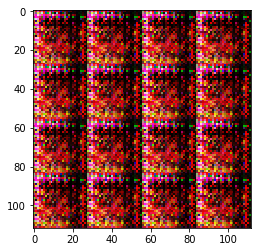

Epoch 1/1... batch 110/6331... time/batch...0.34s remaining time...2136s Discriminator Loss: 0.3526... Generator Loss: 4.7258
Epoch 1/1... batch 120/6331... time/batch...0.34s remaining time...2120s Discriminator Loss: 0.3713... Generator Loss: 4.3688
Epoch 1/1... batch 130/6331... time/batch...0.34s remaining time...2107s Discriminator Loss: 0.3631... Generator Loss: 8.1312
Epoch 1/1... batch 140/6331... time/batch...0.34s remaining time...2097s Discriminator Loss: 0.3862... Generator Loss: 4.6177
Epoch 1/1... batch 150/6331... time/batch...0.34s remaining time...2086s Discriminator Loss: 0.3918... Generator Loss: 3.6077
Epoch 1/1... batch 160/6331... time/batch...0.34s remaining time...2077s Discriminator Loss: 0.3597... Generator Loss: 5.8340
Epoch 1/1... batch 170/6331... time/batch...0.34s remaining time...2068s Discriminator Loss: 0.3624... Generator Loss: 5.7827
Epoch 1/1... batch 180/6331... time/batch...0.34s remaining time...2060s Discriminator Loss: 0.5756... Generator Loss:

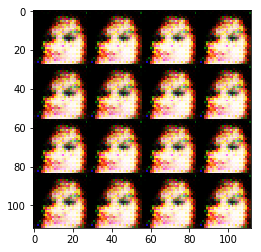

Epoch 1/1... batch 210/6331... time/batch...0.34s remaining time...2058s Discriminator Loss: 0.3751... Generator Loss: 6.8924
Epoch 1/1... batch 220/6331... time/batch...0.34s remaining time...2054s Discriminator Loss: 0.3992... Generator Loss: 3.8870
Epoch 1/1... batch 230/6331... time/batch...0.34s remaining time...2050s Discriminator Loss: 0.3706... Generator Loss: 4.2964
Epoch 1/1... batch 240/6331... time/batch...0.34s remaining time...2045s Discriminator Loss: 0.3631... Generator Loss: 4.0775
Epoch 1/1... batch 250/6331... time/batch...0.34s remaining time...2039s Discriminator Loss: 0.3881... Generator Loss: 3.7883
Epoch 1/1... batch 260/6331... time/batch...0.34s remaining time...2034s Discriminator Loss: 0.3589... Generator Loss: 4.6382
Epoch 1/1... batch 270/6331... time/batch...0.33s remaining time...2030s Discriminator Loss: 0.3609... Generator Loss: 4.2297
Epoch 1/1... batch 280/6331... time/batch...0.33s remaining time...2025s Discriminator Loss: 0.3688... Generator Loss:

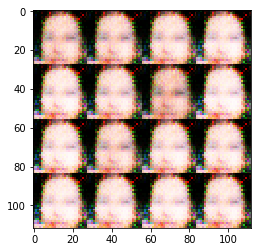

Epoch 1/1... batch 310/6331... time/batch...0.34s remaining time...2018s Discriminator Loss: 1.2056... Generator Loss: 0.9743
Epoch 1/1... batch 320/6331... time/batch...0.33s remaining time...2011s Discriminator Loss: 0.4542... Generator Loss: 4.5327
Epoch 1/1... batch 330/6331... time/batch...0.33s remaining time...2004s Discriminator Loss: 0.3727... Generator Loss: 3.9449
Epoch 1/1... batch 340/6331... time/batch...0.33s remaining time...1998s Discriminator Loss: 0.5196... Generator Loss: 2.6643
Epoch 1/1... batch 350/6331... time/batch...0.33s remaining time...1992s Discriminator Loss: 0.5321... Generator Loss: 2.4835
Epoch 1/1... batch 360/6331... time/batch...0.33s remaining time...1986s Discriminator Loss: 0.6963... Generator Loss: 4.1195
Epoch 1/1... batch 370/6331... time/batch...0.33s remaining time...1980s Discriminator Loss: 0.7445... Generator Loss: 3.8153
Epoch 1/1... batch 380/6331... time/batch...0.33s remaining time...1975s Discriminator Loss: 0.9507... Generator Loss:

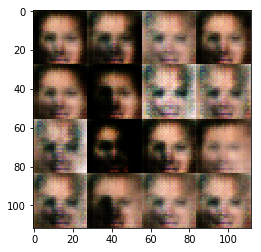

Epoch 1/1... batch 410/6331... time/batch...0.33s remaining time...1967s Discriminator Loss: 0.7053... Generator Loss: 1.9954
Epoch 1/1... batch 420/6331... time/batch...0.33s remaining time...1963s Discriminator Loss: 0.9439... Generator Loss: 1.5486
Epoch 1/1... batch 430/6331... time/batch...0.33s remaining time...1958s Discriminator Loss: 1.7276... Generator Loss: 0.6803
Epoch 1/1... batch 440/6331... time/batch...0.33s remaining time...1954s Discriminator Loss: 0.6522... Generator Loss: 2.2727
Epoch 1/1... batch 450/6331... time/batch...0.33s remaining time...1950s Discriminator Loss: 0.5295... Generator Loss: 2.7166
Epoch 1/1... batch 460/6331... time/batch...0.33s remaining time...1946s Discriminator Loss: 0.7996... Generator Loss: 1.2231
Epoch 1/1... batch 470/6331... time/batch...0.33s remaining time...1942s Discriminator Loss: 1.4910... Generator Loss: 0.9358
Epoch 1/1... batch 480/6331... time/batch...0.33s remaining time...1938s Discriminator Loss: 0.9702... Generator Loss:

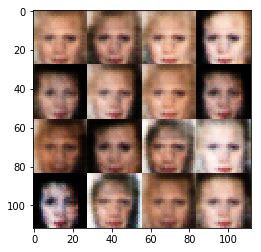

Epoch 1/1... batch 510/6331... time/batch...0.33s remaining time...1933s Discriminator Loss: 0.8391... Generator Loss: 1.2746
Epoch 1/1... batch 520/6331... time/batch...0.33s remaining time...1929s Discriminator Loss: 0.6119... Generator Loss: 2.4910
Epoch 1/1... batch 530/6331... time/batch...0.33s remaining time...1925s Discriminator Loss: 0.6616... Generator Loss: 2.0767
Epoch 1/1... batch 540/6331... time/batch...0.33s remaining time...1921s Discriminator Loss: 0.4857... Generator Loss: 2.1971
Epoch 1/1... batch 550/6331... time/batch...0.33s remaining time...1917s Discriminator Loss: 0.7050... Generator Loss: 1.6463
Epoch 1/1... batch 560/6331... time/batch...0.33s remaining time...1914s Discriminator Loss: 0.8066... Generator Loss: 1.4072
Epoch 1/1... batch 570/6331... time/batch...0.33s remaining time...1910s Discriminator Loss: 0.5602... Generator Loss: 2.4219
Epoch 1/1... batch 580/6331... time/batch...0.33s remaining time...1906s Discriminator Loss: 0.8337... Generator Loss:

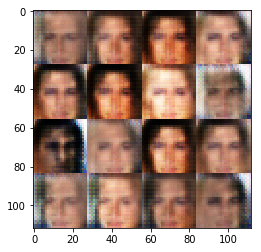

Epoch 1/1... batch 610/6331... time/batch...0.33s remaining time...1900s Discriminator Loss: 0.8685... Generator Loss: 1.4669
Epoch 1/1... batch 620/6331... time/batch...0.33s remaining time...1895s Discriminator Loss: 0.6188... Generator Loss: 2.1787
Epoch 1/1... batch 630/6331... time/batch...0.33s remaining time...1890s Discriminator Loss: 0.9631... Generator Loss: 1.3294
Epoch 1/1... batch 640/6331... time/batch...0.33s remaining time...1885s Discriminator Loss: 1.0434... Generator Loss: 0.9043
Epoch 1/1... batch 650/6331... time/batch...0.33s remaining time...1881s Discriminator Loss: 0.7790... Generator Loss: 1.9354
Epoch 1/1... batch 660/6331... time/batch...0.33s remaining time...1876s Discriminator Loss: 0.8210... Generator Loss: 1.3767
Epoch 1/1... batch 670/6331... time/batch...0.33s remaining time...1871s Discriminator Loss: 0.7406... Generator Loss: 1.5125
Epoch 1/1... batch 680/6331... time/batch...0.33s remaining time...1867s Discriminator Loss: 1.2134... Generator Loss:

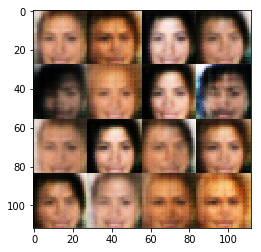

Epoch 1/1... batch 710/6331... time/batch...0.33s remaining time...1859s Discriminator Loss: 0.6454... Generator Loss: 2.4464
Epoch 1/1... batch 720/6331... time/batch...0.33s remaining time...1854s Discriminator Loss: 0.6847... Generator Loss: 1.6330
Epoch 1/1... batch 730/6331... time/batch...0.33s remaining time...1850s Discriminator Loss: 0.8534... Generator Loss: 1.3126
Epoch 1/1... batch 740/6331... time/batch...0.33s remaining time...1845s Discriminator Loss: 0.7781... Generator Loss: 1.4795
Epoch 1/1... batch 750/6331... time/batch...0.33s remaining time...1841s Discriminator Loss: 0.6152... Generator Loss: 2.0052
Epoch 1/1... batch 760/6331... time/batch...0.33s remaining time...1838s Discriminator Loss: 1.0981... Generator Loss: 0.8774
Epoch 1/1... batch 770/6331... time/batch...0.33s remaining time...1834s Discriminator Loss: 1.0361... Generator Loss: 1.2399
Epoch 1/1... batch 780/6331... time/batch...0.33s remaining time...1829s Discriminator Loss: 0.7712... Generator Loss:

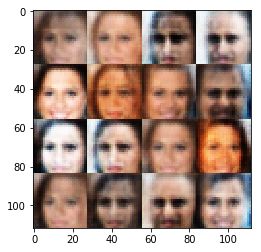

Epoch 1/1... batch 810/6331... time/batch...0.33s remaining time...1819s Discriminator Loss: 0.6025... Generator Loss: 2.5485
Epoch 1/1... batch 820/6331... time/batch...0.33s remaining time...1814s Discriminator Loss: 0.8139... Generator Loss: 1.4492
Epoch 1/1... batch 830/6331... time/batch...0.33s remaining time...1810s Discriminator Loss: 0.7190... Generator Loss: 1.4343
Epoch 1/1... batch 840/6331... time/batch...0.33s remaining time...1806s Discriminator Loss: 0.7594... Generator Loss: 1.8479
Epoch 1/1... batch 850/6331... time/batch...0.33s remaining time...1802s Discriminator Loss: 0.7604... Generator Loss: 1.2372
Epoch 1/1... batch 860/6331... time/batch...0.33s remaining time...1797s Discriminator Loss: 1.0681... Generator Loss: 0.8861
Epoch 1/1... batch 870/6331... time/batch...0.33s remaining time...1793s Discriminator Loss: 0.5639... Generator Loss: 2.0764
Epoch 1/1... batch 880/6331... time/batch...0.33s remaining time...1789s Discriminator Loss: 0.5615... Generator Loss:

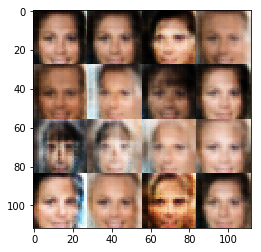

Epoch 1/1... batch 910/6331... time/batch...0.33s remaining time...1779s Discriminator Loss: 0.5655... Generator Loss: 2.4428
Epoch 1/1... batch 920/6331... time/batch...0.33s remaining time...1775s Discriminator Loss: 0.6210... Generator Loss: 2.7496
Epoch 1/1... batch 930/6331... time/batch...0.33s remaining time...1771s Discriminator Loss: 0.9196... Generator Loss: 1.0964
Epoch 1/1... batch 940/6331... time/batch...0.33s remaining time...1768s Discriminator Loss: 0.9800... Generator Loss: 1.1470
Epoch 1/1... batch 950/6331... time/batch...0.33s remaining time...1764s Discriminator Loss: 0.9089... Generator Loss: 1.3994
Epoch 1/1... batch 960/6331... time/batch...0.33s remaining time...1760s Discriminator Loss: 0.7364... Generator Loss: 1.5026
Epoch 1/1... batch 970/6331... time/batch...0.33s remaining time...1756s Discriminator Loss: 0.6990... Generator Loss: 1.9912
Epoch 1/1... batch 980/6331... time/batch...0.33s remaining time...1752s Discriminator Loss: 0.5465... Generator Loss:

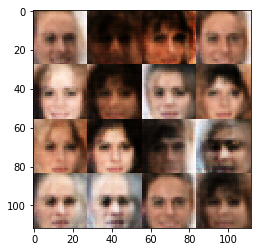

Epoch 1/1... batch 1010/6331... time/batch...0.33s remaining time...1743s Discriminator Loss: 0.5832... Generator Loss: 1.9116
Epoch 1/1... batch 1020/6331... time/batch...0.33s remaining time...1739s Discriminator Loss: 0.8142... Generator Loss: 1.2943
Epoch 1/1... batch 1030/6331... time/batch...0.33s remaining time...1735s Discriminator Loss: 0.6833... Generator Loss: 3.1159
Epoch 1/1... batch 1040/6331... time/batch...0.33s remaining time...1731s Discriminator Loss: 0.5809... Generator Loss: 1.8895
Epoch 1/1... batch 1050/6331... time/batch...0.33s remaining time...1728s Discriminator Loss: 0.6768... Generator Loss: 1.7924
Epoch 1/1... batch 1060/6331... time/batch...0.33s remaining time...1724s Discriminator Loss: 0.6319... Generator Loss: 1.7481
Epoch 1/1... batch 1070/6331... time/batch...0.33s remaining time...1720s Discriminator Loss: 0.7499... Generator Loss: 2.6656
Epoch 1/1... batch 1080/6331... time/batch...0.33s remaining time...1717s Discriminator Loss: 0.7752... Generat

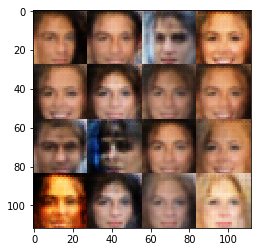

Epoch 1/1... batch 1110/6331... time/batch...0.33s remaining time...1709s Discriminator Loss: 0.5174... Generator Loss: 2.2766
Epoch 1/1... batch 1120/6331... time/batch...0.33s remaining time...1706s Discriminator Loss: 0.5728... Generator Loss: 1.5808
Epoch 1/1... batch 1130/6331... time/batch...0.33s remaining time...1702s Discriminator Loss: 0.7887... Generator Loss: 1.8345
Epoch 1/1... batch 1140/6331... time/batch...0.33s remaining time...1699s Discriminator Loss: 1.0501... Generator Loss: 1.1825
Epoch 1/1... batch 1150/6331... time/batch...0.33s remaining time...1695s Discriminator Loss: 0.6087... Generator Loss: 1.8015
Epoch 1/1... batch 1160/6331... time/batch...0.33s remaining time...1692s Discriminator Loss: 0.6152... Generator Loss: 1.8786
Epoch 1/1... batch 1170/6331... time/batch...0.33s remaining time...1688s Discriminator Loss: 0.5403... Generator Loss: 2.6520
Epoch 1/1... batch 1180/6331... time/batch...0.33s remaining time...1685s Discriminator Loss: 0.5783... Generat

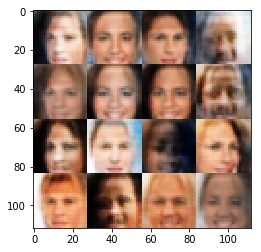

Epoch 1/1... batch 1210/6331... time/batch...0.33s remaining time...1678s Discriminator Loss: 0.5802... Generator Loss: 1.9470
Epoch 1/1... batch 1220/6331... time/batch...0.33s remaining time...1674s Discriminator Loss: 0.6259... Generator Loss: 1.5178
Epoch 1/1... batch 1230/6331... time/batch...0.33s remaining time...1671s Discriminator Loss: 0.6484... Generator Loss: 1.5973
Epoch 1/1... batch 1240/6331... time/batch...0.33s remaining time...1668s Discriminator Loss: 0.5809... Generator Loss: 1.7863
Epoch 1/1... batch 1250/6331... time/batch...0.33s remaining time...1664s Discriminator Loss: 0.7244... Generator Loss: 1.5257
Epoch 1/1... batch 1260/6331... time/batch...0.33s remaining time...1661s Discriminator Loss: 0.6018... Generator Loss: 1.8212
Epoch 1/1... batch 1270/6331... time/batch...0.33s remaining time...1657s Discriminator Loss: 0.5210... Generator Loss: 2.6406
Epoch 1/1... batch 1280/6331... time/batch...0.33s remaining time...1654s Discriminator Loss: 0.6765... Generat

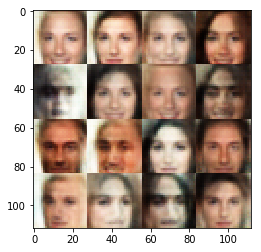

Epoch 1/1... batch 1310/6331... time/batch...0.33s remaining time...1646s Discriminator Loss: 0.7735... Generator Loss: 1.4718
Epoch 1/1... batch 1320/6331... time/batch...0.33s remaining time...1642s Discriminator Loss: 0.6083... Generator Loss: 2.6939
Epoch 1/1... batch 1330/6331... time/batch...0.33s remaining time...1639s Discriminator Loss: 0.5286... Generator Loss: 3.0116
Epoch 1/1... batch 1340/6331... time/batch...0.33s remaining time...1636s Discriminator Loss: 0.5305... Generator Loss: 2.2850
Epoch 1/1... batch 1350/6331... time/batch...0.33s remaining time...1632s Discriminator Loss: 0.7331... Generator Loss: 1.7199
Epoch 1/1... batch 1360/6331... time/batch...0.33s remaining time...1629s Discriminator Loss: 0.8280... Generator Loss: 2.6468
Epoch 1/1... batch 1370/6331... time/batch...0.33s remaining time...1626s Discriminator Loss: 0.7300... Generator Loss: 1.8631
Epoch 1/1... batch 1380/6331... time/batch...0.33s remaining time...1622s Discriminator Loss: 0.6395... Generat

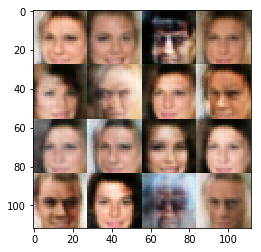

Epoch 1/1... batch 1410/6331... time/batch...0.33s remaining time...1614s Discriminator Loss: 0.6241... Generator Loss: 2.0162
Epoch 1/1... batch 1420/6331... time/batch...0.33s remaining time...1610s Discriminator Loss: 0.5178... Generator Loss: 1.9214
Epoch 1/1... batch 1430/6331... time/batch...0.33s remaining time...1606s Discriminator Loss: 0.5948... Generator Loss: 1.9810
Epoch 1/1... batch 1440/6331... time/batch...0.33s remaining time...1603s Discriminator Loss: 0.5254... Generator Loss: 2.6654
Epoch 1/1... batch 1450/6331... time/batch...0.33s remaining time...1599s Discriminator Loss: 0.5559... Generator Loss: 2.6017
Epoch 1/1... batch 1460/6331... time/batch...0.33s remaining time...1595s Discriminator Loss: 0.5277... Generator Loss: 2.3768
Epoch 1/1... batch 1470/6331... time/batch...0.33s remaining time...1592s Discriminator Loss: 0.6595... Generator Loss: 2.3852
Epoch 1/1... batch 1480/6331... time/batch...0.33s remaining time...1588s Discriminator Loss: 0.6593... Generat

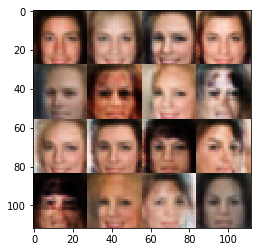

Epoch 1/1... batch 1510/6331... time/batch...0.33s remaining time...1579s Discriminator Loss: 0.5713... Generator Loss: 2.1292
Epoch 1/1... batch 1520/6331... time/batch...0.33s remaining time...1575s Discriminator Loss: 0.5179... Generator Loss: 2.4713
Epoch 1/1... batch 1530/6331... time/batch...0.33s remaining time...1572s Discriminator Loss: 0.9019... Generator Loss: 1.7850
Epoch 1/1... batch 1540/6331... time/batch...0.33s remaining time...1568s Discriminator Loss: 0.4770... Generator Loss: 2.3890
Epoch 1/1... batch 1550/6331... time/batch...0.33s remaining time...1564s Discriminator Loss: 0.5145... Generator Loss: 2.0539
Epoch 1/1... batch 1560/6331... time/batch...0.33s remaining time...1561s Discriminator Loss: 0.6489... Generator Loss: 1.9062
Epoch 1/1... batch 1570/6331... time/batch...0.33s remaining time...1558s Discriminator Loss: 0.4597... Generator Loss: 3.1478
Epoch 1/1... batch 1580/6331... time/batch...0.33s remaining time...1554s Discriminator Loss: 0.7416... Generat

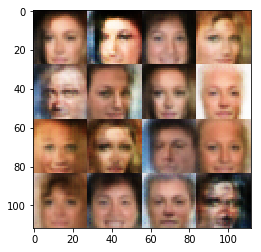

Epoch 1/1... batch 1610/6331... time/batch...0.33s remaining time...1545s Discriminator Loss: 0.7502... Generator Loss: 1.8962
Epoch 1/1... batch 1620/6331... time/batch...0.33s remaining time...1542s Discriminator Loss: 0.5154... Generator Loss: 3.1389
Epoch 1/1... batch 1630/6331... time/batch...0.33s remaining time...1538s Discriminator Loss: 0.5353... Generator Loss: 3.2828
Epoch 1/1... batch 1640/6331... time/batch...0.33s remaining time...1535s Discriminator Loss: 0.6568... Generator Loss: 1.9702
Epoch 1/1... batch 1650/6331... time/batch...0.33s remaining time...1531s Discriminator Loss: 0.5666... Generator Loss: 2.1979
Epoch 1/1... batch 1660/6331... time/batch...0.33s remaining time...1527s Discriminator Loss: 0.6118... Generator Loss: 2.2590
Epoch 1/1... batch 1670/6331... time/batch...0.33s remaining time...1524s Discriminator Loss: 1.0442... Generator Loss: 1.3517
Epoch 1/1... batch 1680/6331... time/batch...0.33s remaining time...1520s Discriminator Loss: 0.6787... Generat

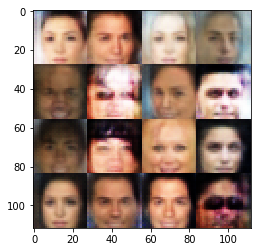

Epoch 1/1... batch 1710/6331... time/batch...0.33s remaining time...1511s Discriminator Loss: 0.5361... Generator Loss: 2.4611
Epoch 1/1... batch 1720/6331... time/batch...0.33s remaining time...1507s Discriminator Loss: 0.5769... Generator Loss: 2.4280
Epoch 1/1... batch 1730/6331... time/batch...0.33s remaining time...1504s Discriminator Loss: 0.6315... Generator Loss: 2.0239
Epoch 1/1... batch 1740/6331... time/batch...0.33s remaining time...1500s Discriminator Loss: 0.6010... Generator Loss: 1.7465
Epoch 1/1... batch 1750/6331... time/batch...0.33s remaining time...1497s Discriminator Loss: 0.4971... Generator Loss: 2.4393
Epoch 1/1... batch 1760/6331... time/batch...0.33s remaining time...1493s Discriminator Loss: 0.5145... Generator Loss: 2.3334
Epoch 1/1... batch 1770/6331... time/batch...0.33s remaining time...1489s Discriminator Loss: 1.4323... Generator Loss: 0.9591
Epoch 1/1... batch 1780/6331... time/batch...0.33s remaining time...1486s Discriminator Loss: 0.8279... Generat

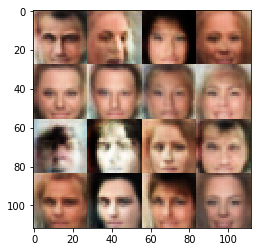

Epoch 1/1... batch 1810/6331... time/batch...0.33s remaining time...1477s Discriminator Loss: 0.4403... Generator Loss: 2.8212
Epoch 1/1... batch 1820/6331... time/batch...0.33s remaining time...1474s Discriminator Loss: 0.6887... Generator Loss: 1.9508
Epoch 1/1... batch 1830/6331... time/batch...0.33s remaining time...1470s Discriminator Loss: 0.9201... Generator Loss: 1.7132
Epoch 1/1... batch 1840/6331... time/batch...0.33s remaining time...1467s Discriminator Loss: 0.5169... Generator Loss: 1.9656
Epoch 1/1... batch 1850/6331... time/batch...0.33s remaining time...1463s Discriminator Loss: 0.4567... Generator Loss: 3.2671
Epoch 1/1... batch 1860/6331... time/batch...0.33s remaining time...1460s Discriminator Loss: 0.7138... Generator Loss: 1.9569
Epoch 1/1... batch 1870/6331... time/batch...0.33s remaining time...1456s Discriminator Loss: 0.6747... Generator Loss: 2.0845
Epoch 1/1... batch 1880/6331... time/batch...0.33s remaining time...1452s Discriminator Loss: 0.5518... Generat

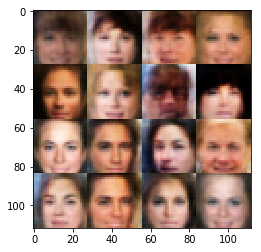

Epoch 1/1... batch 1910/6331... time/batch...0.33s remaining time...1443s Discriminator Loss: 0.5229... Generator Loss: 2.0297
Epoch 1/1... batch 1920/6331... time/batch...0.33s remaining time...1440s Discriminator Loss: 0.7038... Generator Loss: 2.2197
Epoch 1/1... batch 1930/6331... time/batch...0.33s remaining time...1436s Discriminator Loss: 0.6190... Generator Loss: 3.0611
Epoch 1/1... batch 1940/6331... time/batch...0.33s remaining time...1433s Discriminator Loss: 0.5361... Generator Loss: 2.0445
Epoch 1/1... batch 1950/6331... time/batch...0.33s remaining time...1429s Discriminator Loss: 0.5857... Generator Loss: 2.2656
Epoch 1/1... batch 1960/6331... time/batch...0.33s remaining time...1426s Discriminator Loss: 0.5264... Generator Loss: 2.9321
Epoch 1/1... batch 1970/6331... time/batch...0.33s remaining time...1422s Discriminator Loss: 0.5628... Generator Loss: 3.4075
Epoch 1/1... batch 1980/6331... time/batch...0.33s remaining time...1419s Discriminator Loss: 0.4133... Generat

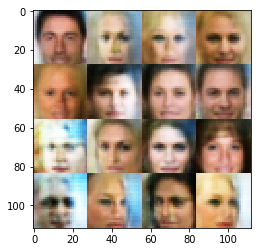

Epoch 1/1... batch 2010/6331... time/batch...0.33s remaining time...1409s Discriminator Loss: 0.8046... Generator Loss: 1.6213
Epoch 1/1... batch 2020/6331... time/batch...0.33s remaining time...1406s Discriminator Loss: 0.4882... Generator Loss: 2.8497
Epoch 1/1... batch 2030/6331... time/batch...0.33s remaining time...1402s Discriminator Loss: 0.4305... Generator Loss: 2.8902
Epoch 1/1... batch 2040/6331... time/batch...0.33s remaining time...1399s Discriminator Loss: 0.4293... Generator Loss: 2.6233
Epoch 1/1... batch 2050/6331... time/batch...0.33s remaining time...1395s Discriminator Loss: 0.4683... Generator Loss: 3.0160
Epoch 1/1... batch 2060/6331... time/batch...0.33s remaining time...1392s Discriminator Loss: 0.4818... Generator Loss: 3.7938
Epoch 1/1... batch 2070/6331... time/batch...0.33s remaining time...1389s Discriminator Loss: 0.4828... Generator Loss: 2.9852
Epoch 1/1... batch 2080/6331... time/batch...0.33s remaining time...1385s Discriminator Loss: 0.5806... Generat

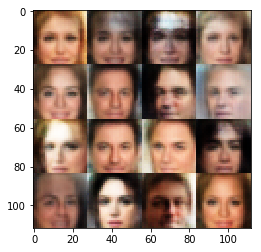

Epoch 1/1... batch 2110/6331... time/batch...0.33s remaining time...1376s Discriminator Loss: 0.6112... Generator Loss: 4.2449
Epoch 1/1... batch 2120/6331... time/batch...0.33s remaining time...1372s Discriminator Loss: 1.2940... Generator Loss: 3.8258
Epoch 1/1... batch 2130/6331... time/batch...0.33s remaining time...1369s Discriminator Loss: 0.5755... Generator Loss: 3.4882
Epoch 1/1... batch 2140/6331... time/batch...0.33s remaining time...1365s Discriminator Loss: 0.4680... Generator Loss: 3.3081
Epoch 1/1... batch 2150/6331... time/batch...0.33s remaining time...1362s Discriminator Loss: 0.4835... Generator Loss: 2.8786
Epoch 1/1... batch 2160/6331... time/batch...0.33s remaining time...1358s Discriminator Loss: 0.5810... Generator Loss: 2.6462
Epoch 1/1... batch 2170/6331... time/batch...0.33s remaining time...1355s Discriminator Loss: 0.6625... Generator Loss: 2.3262
Epoch 1/1... batch 2180/6331... time/batch...0.33s remaining time...1352s Discriminator Loss: 0.4872... Generat

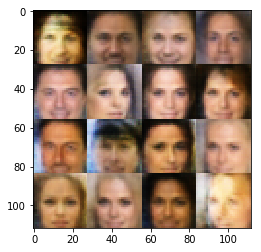

Epoch 1/1... batch 2210/6331... time/batch...0.33s remaining time...1342s Discriminator Loss: 0.5322... Generator Loss: 1.9572
Epoch 1/1... batch 2220/6331... time/batch...0.33s remaining time...1339s Discriminator Loss: 0.5498... Generator Loss: 2.8296
Epoch 1/1... batch 2230/6331... time/batch...0.33s remaining time...1335s Discriminator Loss: 0.4724... Generator Loss: 2.7359
Epoch 1/1... batch 2240/6331... time/batch...0.33s remaining time...1332s Discriminator Loss: 0.4641... Generator Loss: 2.4494
Epoch 1/1... batch 2250/6331... time/batch...0.33s remaining time...1329s Discriminator Loss: 1.0167... Generator Loss: 2.8764
Epoch 1/1... batch 2260/6331... time/batch...0.33s remaining time...1325s Discriminator Loss: 0.4628... Generator Loss: 3.5177
Epoch 1/1... batch 2270/6331... time/batch...0.33s remaining time...1322s Discriminator Loss: 0.5690... Generator Loss: 2.2058
Epoch 1/1... batch 2280/6331... time/batch...0.33s remaining time...1319s Discriminator Loss: 0.4914... Generat

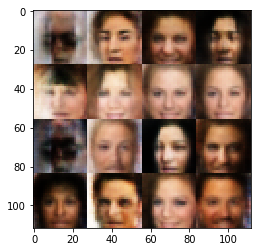

Epoch 1/1... batch 2310/6331... time/batch...0.33s remaining time...1310s Discriminator Loss: 0.5183... Generator Loss: 3.3087
Epoch 1/1... batch 2320/6331... time/batch...0.33s remaining time...1306s Discriminator Loss: 0.4076... Generator Loss: 2.7411
Epoch 1/1... batch 2330/6331... time/batch...0.33s remaining time...1303s Discriminator Loss: 0.6660... Generator Loss: 2.1554
Epoch 1/1... batch 2340/6331... time/batch...0.33s remaining time...1300s Discriminator Loss: 0.5289... Generator Loss: 2.2353
Epoch 1/1... batch 2350/6331... time/batch...0.33s remaining time...1296s Discriminator Loss: 0.5757... Generator Loss: 2.1119
Epoch 1/1... batch 2360/6331... time/batch...0.33s remaining time...1293s Discriminator Loss: 0.5153... Generator Loss: 2.2727
Epoch 1/1... batch 2370/6331... time/batch...0.33s remaining time...1290s Discriminator Loss: 0.4426... Generator Loss: 2.8784
Epoch 1/1... batch 2380/6331... time/batch...0.33s remaining time...1286s Discriminator Loss: 0.6148... Generat

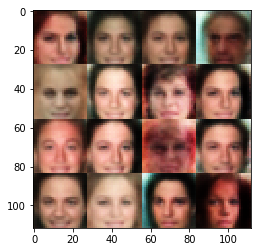

Epoch 1/1... batch 2410/6331... time/batch...0.33s remaining time...1278s Discriminator Loss: 0.7536... Generator Loss: 1.7083
Epoch 1/1... batch 2420/6331... time/batch...0.33s remaining time...1274s Discriminator Loss: 0.5418... Generator Loss: 2.7353
Epoch 1/1... batch 2430/6331... time/batch...0.33s remaining time...1271s Discriminator Loss: 0.4790... Generator Loss: 2.9650
Epoch 1/1... batch 2440/6331... time/batch...0.33s remaining time...1267s Discriminator Loss: 0.7211... Generator Loss: 1.7113
Epoch 1/1... batch 2450/6331... time/batch...0.33s remaining time...1264s Discriminator Loss: 0.6545... Generator Loss: 2.0575
Epoch 1/1... batch 2460/6331... time/batch...0.33s remaining time...1261s Discriminator Loss: 0.7340... Generator Loss: 2.0006
Epoch 1/1... batch 2470/6331... time/batch...0.33s remaining time...1257s Discriminator Loss: 0.4061... Generator Loss: 3.4961
Epoch 1/1... batch 2480/6331... time/batch...0.33s remaining time...1254s Discriminator Loss: 0.4602... Generat

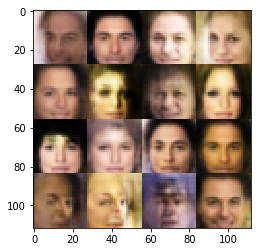

Epoch 1/1... batch 2510/6331... time/batch...0.33s remaining time...1245s Discriminator Loss: 0.4144... Generator Loss: 2.6786
Epoch 1/1... batch 2520/6331... time/batch...0.33s remaining time...1241s Discriminator Loss: 0.5730... Generator Loss: 3.5560
Epoch 1/1... batch 2530/6331... time/batch...0.33s remaining time...1238s Discriminator Loss: 0.4705... Generator Loss: 3.1255
Epoch 1/1... batch 2540/6331... time/batch...0.33s remaining time...1235s Discriminator Loss: 0.8116... Generator Loss: 1.6486
Epoch 1/1... batch 2550/6331... time/batch...0.33s remaining time...1232s Discriminator Loss: 0.4459... Generator Loss: 3.4097
Epoch 1/1... batch 2560/6331... time/batch...0.33s remaining time...1228s Discriminator Loss: 0.5524... Generator Loss: 1.6713
Epoch 1/1... batch 2570/6331... time/batch...0.33s remaining time...1225s Discriminator Loss: 0.4448... Generator Loss: 2.6950
Epoch 1/1... batch 2580/6331... time/batch...0.33s remaining time...1222s Discriminator Loss: 0.4917... Generat

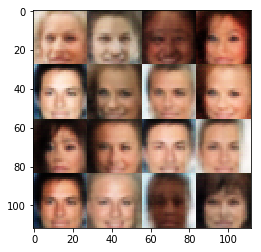

Epoch 1/1... batch 2610/6331... time/batch...0.33s remaining time...1213s Discriminator Loss: 0.5968... Generator Loss: 3.3748
Epoch 1/1... batch 2620/6331... time/batch...0.33s remaining time...1210s Discriminator Loss: 0.4623... Generator Loss: 3.1368
Epoch 1/1... batch 2630/6331... time/batch...0.33s remaining time...1207s Discriminator Loss: 0.5012... Generator Loss: 2.7270
Epoch 1/1... batch 2640/6331... time/batch...0.33s remaining time...1204s Discriminator Loss: 0.4107... Generator Loss: 3.5061
Epoch 1/1... batch 2650/6331... time/batch...0.33s remaining time...1201s Discriminator Loss: 0.5696... Generator Loss: 1.9115
Epoch 1/1... batch 2660/6331... time/batch...0.33s remaining time...1197s Discriminator Loss: 0.5245... Generator Loss: 2.1131
Epoch 1/1... batch 2670/6331... time/batch...0.33s remaining time...1194s Discriminator Loss: 0.5939... Generator Loss: 2.0821
Epoch 1/1... batch 2680/6331... time/batch...0.33s remaining time...1191s Discriminator Loss: 0.5222... Generat

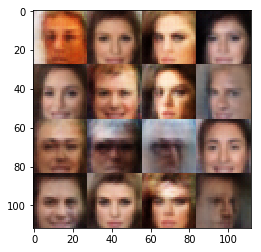

Epoch 1/1... batch 2710/6331... time/batch...0.33s remaining time...1182s Discriminator Loss: 0.6539... Generator Loss: 2.7500
Epoch 1/1... batch 2720/6331... time/batch...0.33s remaining time...1178s Discriminator Loss: 0.5292... Generator Loss: 3.2231
Epoch 1/1... batch 2730/6331... time/batch...0.33s remaining time...1175s Discriminator Loss: 0.5343... Generator Loss: 2.0743
Epoch 1/1... batch 2740/6331... time/batch...0.33s remaining time...1171s Discriminator Loss: 0.4449... Generator Loss: 3.3868
Epoch 1/1... batch 2750/6331... time/batch...0.33s remaining time...1168s Discriminator Loss: 0.7244... Generator Loss: 1.6135
Epoch 1/1... batch 2760/6331... time/batch...0.33s remaining time...1165s Discriminator Loss: 0.5729... Generator Loss: 2.6603
Epoch 1/1... batch 2770/6331... time/batch...0.33s remaining time...1161s Discriminator Loss: 0.6023... Generator Loss: 2.5993
Epoch 1/1... batch 2780/6331... time/batch...0.33s remaining time...1158s Discriminator Loss: 0.7378... Generat

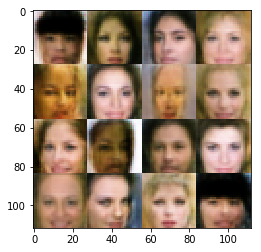

Epoch 1/1... batch 2810/6331... time/batch...0.33s remaining time...1149s Discriminator Loss: 0.4313... Generator Loss: 2.7820
Epoch 1/1... batch 2820/6331... time/batch...0.33s remaining time...1146s Discriminator Loss: 0.7681... Generator Loss: 2.3739
Epoch 1/1... batch 2830/6331... time/batch...0.33s remaining time...1142s Discriminator Loss: 0.3941... Generator Loss: 3.3968
Epoch 1/1... batch 2840/6331... time/batch...0.33s remaining time...1139s Discriminator Loss: 1.2924... Generator Loss: 1.2649
Epoch 1/1... batch 2850/6331... time/batch...0.33s remaining time...1136s Discriminator Loss: 0.5106... Generator Loss: 3.7640
Epoch 1/1... batch 2860/6331... time/batch...0.33s remaining time...1132s Discriminator Loss: 0.4784... Generator Loss: 3.2253
Epoch 1/1... batch 2870/6331... time/batch...0.33s remaining time...1129s Discriminator Loss: 0.4279... Generator Loss: 2.8954
Epoch 1/1... batch 2880/6331... time/batch...0.33s remaining time...1126s Discriminator Loss: 0.9923... Generat

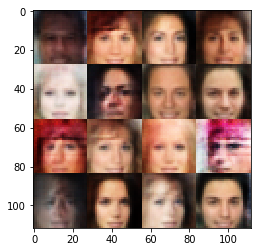

Epoch 1/1... batch 2910/6331... time/batch...0.33s remaining time...1116s Discriminator Loss: 0.4282... Generator Loss: 3.5731
Epoch 1/1... batch 2920/6331... time/batch...0.33s remaining time...1113s Discriminator Loss: 0.6536... Generator Loss: 2.7652
Epoch 1/1... batch 2930/6331... time/batch...0.33s remaining time...1110s Discriminator Loss: 0.4556... Generator Loss: 2.7370
Epoch 1/1... batch 2940/6331... time/batch...0.33s remaining time...1106s Discriminator Loss: 0.5927... Generator Loss: 3.8046
Epoch 1/1... batch 2950/6331... time/batch...0.33s remaining time...1103s Discriminator Loss: 0.9295... Generator Loss: 1.6490
Epoch 1/1... batch 2960/6331... time/batch...0.33s remaining time...1099s Discriminator Loss: 0.6315... Generator Loss: 1.5842
Epoch 1/1... batch 2970/6331... time/batch...0.33s remaining time...1096s Discriminator Loss: 0.4825... Generator Loss: 2.6397
Epoch 1/1... batch 2980/6331... time/batch...0.33s remaining time...1093s Discriminator Loss: 0.8602... Generat

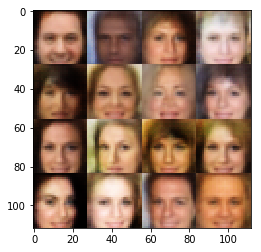

Epoch 1/1... batch 3010/6331... time/batch...0.33s remaining time...1083s Discriminator Loss: 0.4449... Generator Loss: 2.8066
Epoch 1/1... batch 3020/6331... time/batch...0.33s remaining time...1080s Discriminator Loss: 0.4345... Generator Loss: 2.4804
Epoch 1/1... batch 3030/6331... time/batch...0.33s remaining time...1077s Discriminator Loss: 0.5635... Generator Loss: 2.7304
Epoch 1/1... batch 3040/6331... time/batch...0.33s remaining time...1074s Discriminator Loss: 0.5771... Generator Loss: 3.3819
Epoch 1/1... batch 3050/6331... time/batch...0.33s remaining time...1070s Discriminator Loss: 0.4197... Generator Loss: 4.5024
Epoch 1/1... batch 3060/6331... time/batch...0.33s remaining time...1067s Discriminator Loss: 0.4021... Generator Loss: 3.7681
Epoch 1/1... batch 3070/6331... time/batch...0.33s remaining time...1064s Discriminator Loss: 0.6485... Generator Loss: 2.2191
Epoch 1/1... batch 3080/6331... time/batch...0.33s remaining time...1061s Discriminator Loss: 0.5023... Generat

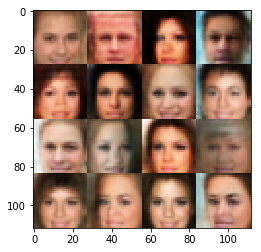

Epoch 1/1... batch 3110/6331... time/batch...0.33s remaining time...1051s Discriminator Loss: 0.5324... Generator Loss: 2.3573
Epoch 1/1... batch 3120/6331... time/batch...0.33s remaining time...1048s Discriminator Loss: 0.3894... Generator Loss: 3.2368
Epoch 1/1... batch 3130/6331... time/batch...0.33s remaining time...1045s Discriminator Loss: 0.3955... Generator Loss: 3.3483
Epoch 1/1... batch 3140/6331... time/batch...0.33s remaining time...1041s Discriminator Loss: 0.4390... Generator Loss: 2.4832
Epoch 1/1... batch 3150/6331... time/batch...0.33s remaining time...1038s Discriminator Loss: 0.4143... Generator Loss: 3.7601
Epoch 1/1... batch 3160/6331... time/batch...0.33s remaining time...1034s Discriminator Loss: 0.4914... Generator Loss: 2.6531
Epoch 1/1... batch 3170/6331... time/batch...0.33s remaining time...1031s Discriminator Loss: 0.4294... Generator Loss: 3.1464
Epoch 1/1... batch 3180/6331... time/batch...0.33s remaining time...1028s Discriminator Loss: 0.5568... Generat

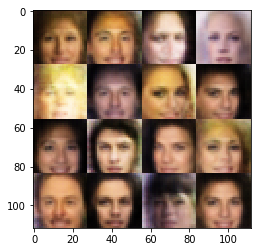

Epoch 1/1... batch 3210/6331... time/batch...0.33s remaining time...1018s Discriminator Loss: 0.5445... Generator Loss: 4.1432
Epoch 1/1... batch 3220/6331... time/batch...0.33s remaining time...1015s Discriminator Loss: 0.8161... Generator Loss: 1.7096
Epoch 1/1... batch 3230/6331... time/batch...0.33s remaining time...1011s Discriminator Loss: 0.4767... Generator Loss: 2.3803
Epoch 1/1... batch 3240/6331... time/batch...0.33s remaining time...1008s Discriminator Loss: 0.4316... Generator Loss: 2.5075
Epoch 1/1... batch 3250/6331... time/batch...0.33s remaining time...1005s Discriminator Loss: 0.6377... Generator Loss: 3.8062
Epoch 1/1... batch 3260/6331... time/batch...0.33s remaining time...1002s Discriminator Loss: 0.5772... Generator Loss: 2.4082
Epoch 1/1... batch 3270/6331... time/batch...0.33s remaining time...998s Discriminator Loss: 0.8266... Generator Loss: 1.5978
Epoch 1/1... batch 3280/6331... time/batch...0.33s remaining time...995s Discriminator Loss: 0.5711... Generator

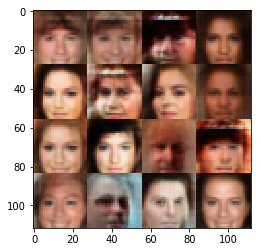

Epoch 1/1... batch 3310/6331... time/batch...0.33s remaining time...985s Discriminator Loss: 0.4456... Generator Loss: 2.6823
Epoch 1/1... batch 3320/6331... time/batch...0.33s remaining time...982s Discriminator Loss: 0.7286... Generator Loss: 2.1082
Epoch 1/1... batch 3330/6331... time/batch...0.33s remaining time...979s Discriminator Loss: 0.5936... Generator Loss: 2.7152
Epoch 1/1... batch 3340/6331... time/batch...0.33s remaining time...976s Discriminator Loss: 0.3782... Generator Loss: 3.4795
Epoch 1/1... batch 3350/6331... time/batch...0.33s remaining time...972s Discriminator Loss: 0.7417... Generator Loss: 3.7908
Epoch 1/1... batch 3360/6331... time/batch...0.33s remaining time...969s Discriminator Loss: 0.4339... Generator Loss: 3.2683
Epoch 1/1... batch 3370/6331... time/batch...0.33s remaining time...966s Discriminator Loss: 0.5062... Generator Loss: 2.3656
Epoch 1/1... batch 3380/6331... time/batch...0.33s remaining time...962s Discriminator Loss: 0.4227... Generator Loss:

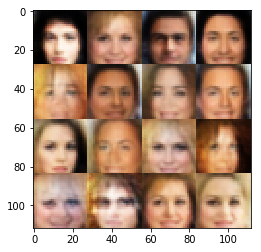

Epoch 1/1... batch 3410/6331... time/batch...0.33s remaining time...953s Discriminator Loss: 0.4674... Generator Loss: 2.9445
Epoch 1/1... batch 3420/6331... time/batch...0.33s remaining time...950s Discriminator Loss: 1.5112... Generator Loss: 0.8455
Epoch 1/1... batch 3430/6331... time/batch...0.33s remaining time...946s Discriminator Loss: 1.1981... Generator Loss: 1.3468
Epoch 1/1... batch 3440/6331... time/batch...0.33s remaining time...943s Discriminator Loss: 0.5523... Generator Loss: 4.2051
Epoch 1/1... batch 3450/6331... time/batch...0.33s remaining time...940s Discriminator Loss: 0.6200... Generator Loss: 1.8736
Epoch 1/1... batch 3460/6331... time/batch...0.33s remaining time...936s Discriminator Loss: 0.7597... Generator Loss: 2.0856
Epoch 1/1... batch 3470/6331... time/batch...0.33s remaining time...933s Discriminator Loss: 0.4613... Generator Loss: 2.4564
Epoch 1/1... batch 3480/6331... time/batch...0.33s remaining time...930s Discriminator Loss: 0.6632... Generator Loss:

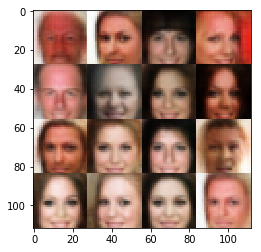

Epoch 1/1... batch 3510/6331... time/batch...0.33s remaining time...920s Discriminator Loss: 0.3708... Generator Loss: 4.3378
Epoch 1/1... batch 3520/6331... time/batch...0.33s remaining time...917s Discriminator Loss: 0.4479... Generator Loss: 2.5196
Epoch 1/1... batch 3530/6331... time/batch...0.33s remaining time...913s Discriminator Loss: 0.6423... Generator Loss: 2.5239
Epoch 1/1... batch 3540/6331... time/batch...0.33s remaining time...910s Discriminator Loss: 0.4193... Generator Loss: 2.9903
Epoch 1/1... batch 3550/6331... time/batch...0.33s remaining time...907s Discriminator Loss: 0.6009... Generator Loss: 2.2266
Epoch 1/1... batch 3560/6331... time/batch...0.33s remaining time...903s Discriminator Loss: 0.8829... Generator Loss: 1.2064
Epoch 1/1... batch 3570/6331... time/batch...0.33s remaining time...900s Discriminator Loss: 0.5062... Generator Loss: 3.0691
Epoch 1/1... batch 3580/6331... time/batch...0.33s remaining time...897s Discriminator Loss: 0.6235... Generator Loss:

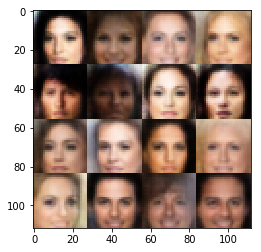

Epoch 1/1... batch 3610/6331... time/batch...0.33s remaining time...887s Discriminator Loss: 0.7943... Generator Loss: 1.8300
Epoch 1/1... batch 3620/6331... time/batch...0.33s remaining time...884s Discriminator Loss: 0.4280... Generator Loss: 3.0333
Epoch 1/1... batch 3630/6331... time/batch...0.33s remaining time...880s Discriminator Loss: 0.4737... Generator Loss: 3.2974
Epoch 1/1... batch 3640/6331... time/batch...0.33s remaining time...877s Discriminator Loss: 0.3950... Generator Loss: 3.4923
Epoch 1/1... batch 3650/6331... time/batch...0.33s remaining time...874s Discriminator Loss: 0.4172... Generator Loss: 3.5828
Epoch 1/1... batch 3660/6331... time/batch...0.33s remaining time...870s Discriminator Loss: 0.3840... Generator Loss: 3.1970
Epoch 1/1... batch 3670/6331... time/batch...0.33s remaining time...867s Discriminator Loss: 0.5655... Generator Loss: 2.3729
Epoch 1/1... batch 3680/6331... time/batch...0.33s remaining time...864s Discriminator Loss: 0.4085... Generator Loss:

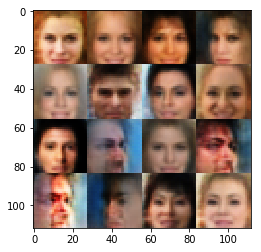

Epoch 1/1... batch 3710/6331... time/batch...0.33s remaining time...854s Discriminator Loss: 0.4091... Generator Loss: 2.9899
Epoch 1/1... batch 3720/6331... time/batch...0.33s remaining time...851s Discriminator Loss: 0.4305... Generator Loss: 3.7517
Epoch 1/1... batch 3730/6331... time/batch...0.33s remaining time...847s Discriminator Loss: 0.4652... Generator Loss: 3.3475
Epoch 1/1... batch 3740/6331... time/batch...0.33s remaining time...844s Discriminator Loss: 1.8787... Generator Loss: 0.9000
Epoch 1/1... batch 3750/6331... time/batch...0.33s remaining time...841s Discriminator Loss: 0.6358... Generator Loss: 2.0906
Epoch 1/1... batch 3760/6331... time/batch...0.33s remaining time...837s Discriminator Loss: 0.6086... Generator Loss: 2.5696
Epoch 1/1... batch 3770/6331... time/batch...0.33s remaining time...834s Discriminator Loss: 0.4122... Generator Loss: 2.9514
Epoch 1/1... batch 3780/6331... time/batch...0.33s remaining time...831s Discriminator Loss: 0.3797... Generator Loss:

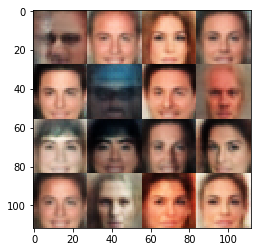

Epoch 1/1... batch 3810/6331... time/batch...0.33s remaining time...821s Discriminator Loss: 0.5237... Generator Loss: 3.3378
Epoch 1/1... batch 3820/6331... time/batch...0.33s remaining time...818s Discriminator Loss: 0.4726... Generator Loss: 2.8332
Epoch 1/1... batch 3830/6331... time/batch...0.33s remaining time...815s Discriminator Loss: 0.4472... Generator Loss: 2.3177
Epoch 1/1... batch 3840/6331... time/batch...0.33s remaining time...811s Discriminator Loss: 0.5244... Generator Loss: 2.7152
Epoch 1/1... batch 3850/6331... time/batch...0.33s remaining time...808s Discriminator Loss: 0.3858... Generator Loss: 4.8085
Epoch 1/1... batch 3860/6331... time/batch...0.33s remaining time...805s Discriminator Loss: 0.3799... Generator Loss: 3.5089
Epoch 1/1... batch 3870/6331... time/batch...0.33s remaining time...801s Discriminator Loss: 0.7281... Generator Loss: 1.8413
Epoch 1/1... batch 3880/6331... time/batch...0.33s remaining time...798s Discriminator Loss: 0.9000... Generator Loss:

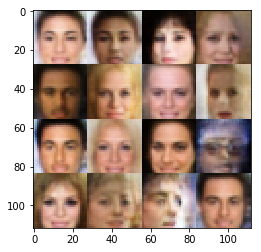

Epoch 1/1... batch 3910/6331... time/batch...0.33s remaining time...788s Discriminator Loss: 0.4574... Generator Loss: 3.1076
Epoch 1/1... batch 3920/6331... time/batch...0.33s remaining time...785s Discriminator Loss: 0.9921... Generator Loss: 1.8000
Epoch 1/1... batch 3930/6331... time/batch...0.33s remaining time...782s Discriminator Loss: 0.4377... Generator Loss: 2.9559
Epoch 1/1... batch 3940/6331... time/batch...0.33s remaining time...779s Discriminator Loss: 0.5092... Generator Loss: 2.7414
Epoch 1/1... batch 3950/6331... time/batch...0.33s remaining time...775s Discriminator Loss: 0.5164... Generator Loss: 3.1148
Epoch 1/1... batch 3960/6331... time/batch...0.33s remaining time...772s Discriminator Loss: 0.6306... Generator Loss: 1.9105
Epoch 1/1... batch 3970/6331... time/batch...0.33s remaining time...769s Discriminator Loss: 0.6882... Generator Loss: 3.9794
Epoch 1/1... batch 3980/6331... time/batch...0.33s remaining time...765s Discriminator Loss: 0.7141... Generator Loss:

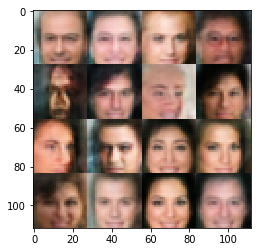

Epoch 1/1... batch 4010/6331... time/batch...0.33s remaining time...756s Discriminator Loss: 0.6426... Generator Loss: 3.3805
Epoch 1/1... batch 4020/6331... time/batch...0.33s remaining time...752s Discriminator Loss: 0.7524... Generator Loss: 2.2119
Epoch 1/1... batch 4030/6331... time/batch...0.33s remaining time...749s Discriminator Loss: 0.5045... Generator Loss: 2.9358
Epoch 1/1... batch 4040/6331... time/batch...0.33s remaining time...746s Discriminator Loss: 0.4979... Generator Loss: 3.4641
Epoch 1/1... batch 4050/6331... time/batch...0.33s remaining time...743s Discriminator Loss: 0.6039... Generator Loss: 1.7664
Epoch 1/1... batch 4060/6331... time/batch...0.33s remaining time...739s Discriminator Loss: 0.5034... Generator Loss: 2.9535
Epoch 1/1... batch 4070/6331... time/batch...0.33s remaining time...736s Discriminator Loss: 0.3902... Generator Loss: 2.7482
Epoch 1/1... batch 4080/6331... time/batch...0.33s remaining time...733s Discriminator Loss: 0.4389... Generator Loss:

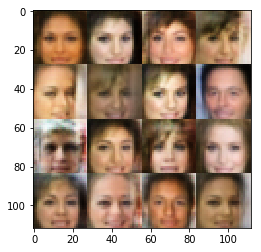

Epoch 1/1... batch 4110/6331... time/batch...0.33s remaining time...723s Discriminator Loss: 0.4099... Generator Loss: 4.4299
Epoch 1/1... batch 4120/6331... time/batch...0.33s remaining time...720s Discriminator Loss: 0.9430... Generator Loss: 1.6382
Epoch 1/1... batch 4130/6331... time/batch...0.33s remaining time...717s Discriminator Loss: 0.3956... Generator Loss: 4.3031
Epoch 1/1... batch 4140/6331... time/batch...0.33s remaining time...713s Discriminator Loss: 0.3831... Generator Loss: 3.5638
Epoch 1/1... batch 4150/6331... time/batch...0.33s remaining time...710s Discriminator Loss: 0.4402... Generator Loss: 2.8743
Epoch 1/1... batch 4160/6331... time/batch...0.33s remaining time...707s Discriminator Loss: 0.4222... Generator Loss: 2.7375
Epoch 1/1... batch 4170/6331... time/batch...0.33s remaining time...704s Discriminator Loss: 0.4243... Generator Loss: 2.4152
Epoch 1/1... batch 4180/6331... time/batch...0.33s remaining time...701s Discriminator Loss: 0.5453... Generator Loss:

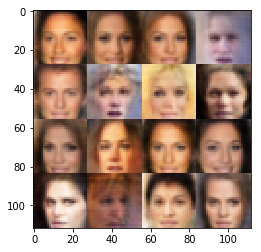

Epoch 1/1... batch 4210/6331... time/batch...0.33s remaining time...691s Discriminator Loss: 0.4625... Generator Loss: 2.5160
Epoch 1/1... batch 4220/6331... time/batch...0.33s remaining time...688s Discriminator Loss: 0.6488... Generator Loss: 2.1405
Epoch 1/1... batch 4230/6331... time/batch...0.33s remaining time...685s Discriminator Loss: 0.3920... Generator Loss: 3.3165
Epoch 1/1... batch 4240/6331... time/batch...0.33s remaining time...681s Discriminator Loss: 0.4817... Generator Loss: 2.9943
Epoch 1/1... batch 4250/6331... time/batch...0.33s remaining time...678s Discriminator Loss: 0.4022... Generator Loss: 3.2368
Epoch 1/1... batch 4260/6331... time/batch...0.33s remaining time...675s Discriminator Loss: 0.4820... Generator Loss: 2.9190
Epoch 1/1... batch 4270/6331... time/batch...0.33s remaining time...671s Discriminator Loss: 0.4454... Generator Loss: 2.7373
Epoch 1/1... batch 4280/6331... time/batch...0.33s remaining time...668s Discriminator Loss: 0.3754... Generator Loss:

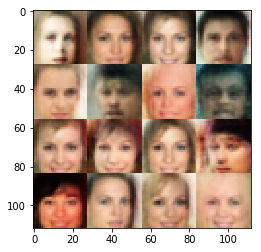

Epoch 1/1... batch 4310/6331... time/batch...0.33s remaining time...658s Discriminator Loss: 0.4344... Generator Loss: 3.9918
Epoch 1/1... batch 4320/6331... time/batch...0.33s remaining time...655s Discriminator Loss: 0.6668... Generator Loss: 2.8167
Epoch 1/1... batch 4330/6331... time/batch...0.33s remaining time...652s Discriminator Loss: 0.4038... Generator Loss: 3.5778
Epoch 1/1... batch 4340/6331... time/batch...0.33s remaining time...649s Discriminator Loss: 0.3846... Generator Loss: 4.4245
Epoch 1/1... batch 4350/6331... time/batch...0.33s remaining time...645s Discriminator Loss: 0.9315... Generator Loss: 1.8581
Epoch 1/1... batch 4360/6331... time/batch...0.33s remaining time...642s Discriminator Loss: 0.6021... Generator Loss: 2.1780
Epoch 1/1... batch 4370/6331... time/batch...0.33s remaining time...639s Discriminator Loss: 0.4748... Generator Loss: 3.1266
Epoch 1/1... batch 4380/6331... time/batch...0.33s remaining time...635s Discriminator Loss: 0.7823... Generator Loss:

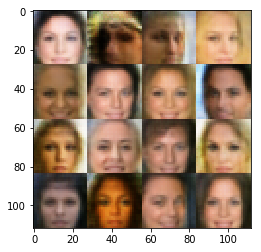

Epoch 1/1... batch 4410/6331... time/batch...0.33s remaining time...626s Discriminator Loss: 0.5378... Generator Loss: 2.9131
Epoch 1/1... batch 4420/6331... time/batch...0.33s remaining time...622s Discriminator Loss: 0.3935... Generator Loss: 2.5250
Epoch 1/1... batch 4430/6331... time/batch...0.33s remaining time...619s Discriminator Loss: 0.4051... Generator Loss: 2.7410
Epoch 1/1... batch 4440/6331... time/batch...0.33s remaining time...616s Discriminator Loss: 0.4034... Generator Loss: 2.8949
Epoch 1/1... batch 4450/6331... time/batch...0.33s remaining time...612s Discriminator Loss: 0.4402... Generator Loss: 2.7618
Epoch 1/1... batch 4460/6331... time/batch...0.33s remaining time...609s Discriminator Loss: 0.4386... Generator Loss: 3.1227
Epoch 1/1... batch 4470/6331... time/batch...0.33s remaining time...606s Discriminator Loss: 0.3959... Generator Loss: 3.4620
Epoch 1/1... batch 4480/6331... time/batch...0.33s remaining time...602s Discriminator Loss: 0.3558... Generator Loss:

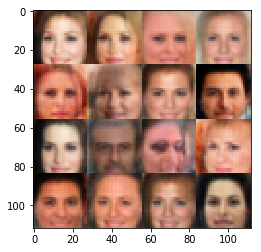

Epoch 1/1... batch 4510/6331... time/batch...0.33s remaining time...593s Discriminator Loss: 0.4086... Generator Loss: 3.3813
Epoch 1/1... batch 4520/6331... time/batch...0.33s remaining time...589s Discriminator Loss: 0.4031... Generator Loss: 3.5045
Epoch 1/1... batch 4530/6331... time/batch...0.33s remaining time...586s Discriminator Loss: 0.3826... Generator Loss: 4.8391
Epoch 1/1... batch 4540/6331... time/batch...0.33s remaining time...583s Discriminator Loss: 0.4370... Generator Loss: 3.7367
Epoch 1/1... batch 4550/6331... time/batch...0.33s remaining time...580s Discriminator Loss: 0.4191... Generator Loss: 2.9216
Epoch 1/1... batch 4560/6331... time/batch...0.33s remaining time...576s Discriminator Loss: 0.5727... Generator Loss: 2.1253
Epoch 1/1... batch 4570/6331... time/batch...0.33s remaining time...573s Discriminator Loss: 0.3893... Generator Loss: 4.1484
Epoch 1/1... batch 4580/6331... time/batch...0.33s remaining time...570s Discriminator Loss: 0.3592... Generator Loss:

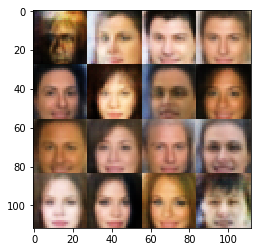

Epoch 1/1... batch 4610/6331... time/batch...0.33s remaining time...560s Discriminator Loss: 0.4165... Generator Loss: 3.3733
Epoch 1/1... batch 4620/6331... time/batch...0.33s remaining time...557s Discriminator Loss: 0.4300... Generator Loss: 3.7587
Epoch 1/1... batch 4630/6331... time/batch...0.33s remaining time...554s Discriminator Loss: 0.4428... Generator Loss: 3.7460
Epoch 1/1... batch 4640/6331... time/batch...0.33s remaining time...550s Discriminator Loss: 0.4226... Generator Loss: 2.0547
Epoch 1/1... batch 4650/6331... time/batch...0.33s remaining time...547s Discriminator Loss: 0.4100... Generator Loss: 3.7759
Epoch 1/1... batch 4660/6331... time/batch...0.33s remaining time...544s Discriminator Loss: 0.3580... Generator Loss: 4.2663
Epoch 1/1... batch 4670/6331... time/batch...0.33s remaining time...541s Discriminator Loss: 0.7046... Generator Loss: 4.7801
Epoch 1/1... batch 4680/6331... time/batch...0.33s remaining time...537s Discriminator Loss: 0.4216... Generator Loss:

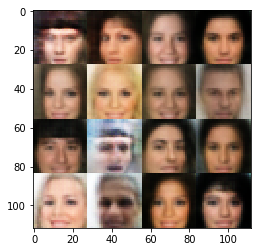

Epoch 1/1... batch 4710/6331... time/batch...0.33s remaining time...528s Discriminator Loss: 0.4829... Generator Loss: 3.0054
Epoch 1/1... batch 4720/6331... time/batch...0.33s remaining time...524s Discriminator Loss: 0.5600... Generator Loss: 2.4866
Epoch 1/1... batch 4730/6331... time/batch...0.33s remaining time...521s Discriminator Loss: 1.0972... Generator Loss: 0.8059
Epoch 1/1... batch 4740/6331... time/batch...0.33s remaining time...518s Discriminator Loss: 0.4207... Generator Loss: 3.8742
Epoch 1/1... batch 4750/6331... time/batch...0.33s remaining time...515s Discriminator Loss: 0.4317... Generator Loss: 3.3852
Epoch 1/1... batch 4760/6331... time/batch...0.33s remaining time...511s Discriminator Loss: 0.4062... Generator Loss: 3.9213
Epoch 1/1... batch 4770/6331... time/batch...0.33s remaining time...508s Discriminator Loss: 0.4462... Generator Loss: 3.8070
Epoch 1/1... batch 4780/6331... time/batch...0.33s remaining time...505s Discriminator Loss: 0.6349... Generator Loss:

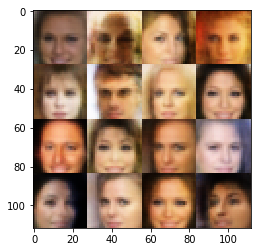

Epoch 1/1... batch 4810/6331... time/batch...0.33s remaining time...495s Discriminator Loss: 0.3896... Generator Loss: 3.3005
Epoch 1/1... batch 4820/6331... time/batch...0.33s remaining time...492s Discriminator Loss: 0.5177... Generator Loss: 2.4520
Epoch 1/1... batch 4830/6331... time/batch...0.33s remaining time...489s Discriminator Loss: 0.3910... Generator Loss: 3.5118
Epoch 1/1... batch 4840/6331... time/batch...0.33s remaining time...485s Discriminator Loss: 0.4021... Generator Loss: 3.8534
Epoch 1/1... batch 4850/6331... time/batch...0.33s remaining time...482s Discriminator Loss: 0.4187... Generator Loss: 3.1386
Epoch 1/1... batch 4860/6331... time/batch...0.33s remaining time...479s Discriminator Loss: 0.7477... Generator Loss: 2.8881
Epoch 1/1... batch 4870/6331... time/batch...0.33s remaining time...475s Discriminator Loss: 0.4076... Generator Loss: 3.4678
Epoch 1/1... batch 4880/6331... time/batch...0.33s remaining time...472s Discriminator Loss: 0.4204... Generator Loss:

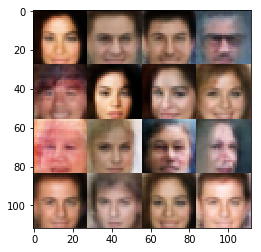

Epoch 1/1... batch 4910/6331... time/batch...0.33s remaining time...463s Discriminator Loss: 0.5919... Generator Loss: 2.2708
Epoch 1/1... batch 4920/6331... time/batch...0.33s remaining time...459s Discriminator Loss: 1.1046... Generator Loss: 1.3617
Epoch 1/1... batch 4930/6331... time/batch...0.33s remaining time...456s Discriminator Loss: 0.5057... Generator Loss: 2.3871
Epoch 1/1... batch 4940/6331... time/batch...0.33s remaining time...453s Discriminator Loss: 0.4591... Generator Loss: 3.3037
Epoch 1/1... batch 4950/6331... time/batch...0.33s remaining time...449s Discriminator Loss: 0.4098... Generator Loss: 3.3799
Epoch 1/1... batch 4960/6331... time/batch...0.33s remaining time...446s Discriminator Loss: 0.3873... Generator Loss: 3.6545
Epoch 1/1... batch 4970/6331... time/batch...0.33s remaining time...443s Discriminator Loss: 0.6132... Generator Loss: 1.9907
Epoch 1/1... batch 4980/6331... time/batch...0.33s remaining time...440s Discriminator Loss: 0.4068... Generator Loss:

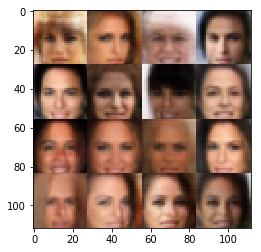

Epoch 1/1... batch 5010/6331... time/batch...0.33s remaining time...430s Discriminator Loss: 0.7945... Generator Loss: 1.6996
Epoch 1/1... batch 5020/6331... time/batch...0.33s remaining time...427s Discriminator Loss: 0.5338... Generator Loss: 2.7820
Epoch 1/1... batch 5030/6331... time/batch...0.33s remaining time...423s Discriminator Loss: 0.6905... Generator Loss: 1.8618
Epoch 1/1... batch 5040/6331... time/batch...0.33s remaining time...420s Discriminator Loss: 1.6020... Generator Loss: 5.6782
Epoch 1/1... batch 5050/6331... time/batch...0.33s remaining time...417s Discriminator Loss: 0.5768... Generator Loss: 2.4970
Epoch 1/1... batch 5060/6331... time/batch...0.33s remaining time...413s Discriminator Loss: 0.5341... Generator Loss: 2.1440
Epoch 1/1... batch 5070/6331... time/batch...0.33s remaining time...410s Discriminator Loss: 0.3872... Generator Loss: 3.1492
Epoch 1/1... batch 5080/6331... time/batch...0.33s remaining time...407s Discriminator Loss: 0.3783... Generator Loss:

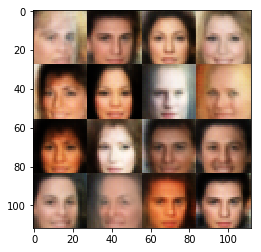

Epoch 1/1... batch 5110/6331... time/batch...0.33s remaining time...397s Discriminator Loss: 0.4056... Generator Loss: 3.9467
Epoch 1/1... batch 5120/6331... time/batch...0.33s remaining time...394s Discriminator Loss: 0.5518... Generator Loss: 3.1206
Epoch 1/1... batch 5130/6331... time/batch...0.33s remaining time...391s Discriminator Loss: 0.5098... Generator Loss: 3.2940
Epoch 1/1... batch 5140/6331... time/batch...0.33s remaining time...388s Discriminator Loss: 0.5460... Generator Loss: 2.2086
Epoch 1/1... batch 5150/6331... time/batch...0.33s remaining time...384s Discriminator Loss: 0.5072... Generator Loss: 3.2881
Epoch 1/1... batch 5160/6331... time/batch...0.33s remaining time...381s Discriminator Loss: 0.4976... Generator Loss: 3.2014
Epoch 1/1... batch 5170/6331... time/batch...0.33s remaining time...378s Discriminator Loss: 0.5513... Generator Loss: 2.5640
Epoch 1/1... batch 5180/6331... time/batch...0.33s remaining time...375s Discriminator Loss: 0.4039... Generator Loss:

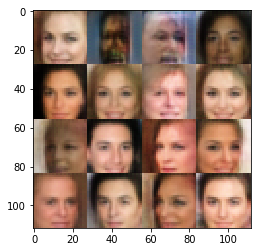

Epoch 1/1... batch 5210/6331... time/batch...0.33s remaining time...365s Discriminator Loss: 0.5552... Generator Loss: 1.8748
Epoch 1/1... batch 5220/6331... time/batch...0.33s remaining time...362s Discriminator Loss: 0.4359... Generator Loss: 3.7227
Epoch 1/1... batch 5230/6331... time/batch...0.33s remaining time...358s Discriminator Loss: 0.7544... Generator Loss: 1.4068
Epoch 1/1... batch 5240/6331... time/batch...0.33s remaining time...355s Discriminator Loss: 0.4082... Generator Loss: 3.4195
Epoch 1/1... batch 5250/6331... time/batch...0.33s remaining time...352s Discriminator Loss: 0.4333... Generator Loss: 2.9936
Epoch 1/1... batch 5260/6331... time/batch...0.33s remaining time...349s Discriminator Loss: 0.4364... Generator Loss: 3.3583
Epoch 1/1... batch 5270/6331... time/batch...0.33s remaining time...345s Discriminator Loss: 0.3933... Generator Loss: 4.0097
Epoch 1/1... batch 5280/6331... time/batch...0.33s remaining time...342s Discriminator Loss: 0.5542... Generator Loss:

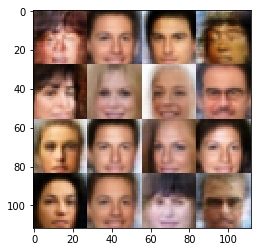

Epoch 1/1... batch 5310/6331... time/batch...0.33s remaining time...332s Discriminator Loss: 1.1961... Generator Loss: 1.1363
Epoch 1/1... batch 5320/6331... time/batch...0.33s remaining time...329s Discriminator Loss: 0.4763... Generator Loss: 2.5070
Epoch 1/1... batch 5330/6331... time/batch...0.33s remaining time...326s Discriminator Loss: 0.6277... Generator Loss: 2.0603
Epoch 1/1... batch 5340/6331... time/batch...0.33s remaining time...323s Discriminator Loss: 0.7208... Generator Loss: 1.1343
Epoch 1/1... batch 5350/6331... time/batch...0.33s remaining time...319s Discriminator Loss: 0.4760... Generator Loss: 2.9623
Epoch 1/1... batch 5360/6331... time/batch...0.33s remaining time...316s Discriminator Loss: 0.6430... Generator Loss: 3.0754
Epoch 1/1... batch 5370/6331... time/batch...0.33s remaining time...313s Discriminator Loss: 0.4108... Generator Loss: 2.5617
Epoch 1/1... batch 5380/6331... time/batch...0.33s remaining time...309s Discriminator Loss: 0.4770... Generator Loss:

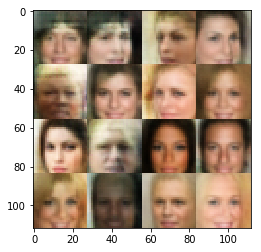

Epoch 1/1... batch 5410/6331... time/batch...0.33s remaining time...300s Discriminator Loss: 0.3744... Generator Loss: 3.9126
Epoch 1/1... batch 5420/6331... time/batch...0.33s remaining time...297s Discriminator Loss: 0.4308... Generator Loss: 4.1922
Epoch 1/1... batch 5430/6331... time/batch...0.33s remaining time...293s Discriminator Loss: 0.5572... Generator Loss: 6.4940
Epoch 1/1... batch 5440/6331... time/batch...0.33s remaining time...290s Discriminator Loss: 0.6545... Generator Loss: 2.2624
Epoch 1/1... batch 5450/6331... time/batch...0.33s remaining time...287s Discriminator Loss: 0.5000... Generator Loss: 3.5692
Epoch 1/1... batch 5460/6331... time/batch...0.33s remaining time...283s Discriminator Loss: 0.3885... Generator Loss: 2.9153
Epoch 1/1... batch 5470/6331... time/batch...0.33s remaining time...280s Discriminator Loss: 0.4617... Generator Loss: 3.3246
Epoch 1/1... batch 5480/6331... time/batch...0.33s remaining time...277s Discriminator Loss: 0.7216... Generator Loss:

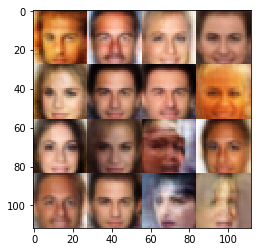

Epoch 1/1... batch 5510/6331... time/batch...0.33s remaining time...267s Discriminator Loss: 0.6302... Generator Loss: 2.5747
Epoch 1/1... batch 5520/6331... time/batch...0.33s remaining time...264s Discriminator Loss: 0.3942... Generator Loss: 4.2901
Epoch 1/1... batch 5530/6331... time/batch...0.33s remaining time...261s Discriminator Loss: 1.1846... Generator Loss: 0.4148
Epoch 1/1... batch 5540/6331... time/batch...0.33s remaining time...257s Discriminator Loss: 0.5095... Generator Loss: 4.6561
Epoch 1/1... batch 5550/6331... time/batch...0.33s remaining time...254s Discriminator Loss: 0.5423... Generator Loss: 2.1569
Epoch 1/1... batch 5560/6331... time/batch...0.33s remaining time...251s Discriminator Loss: 0.7525... Generator Loss: 1.9811
Epoch 1/1... batch 5570/6331... time/batch...0.33s remaining time...248s Discriminator Loss: 0.3763... Generator Loss: 5.4735
Epoch 1/1... batch 5580/6331... time/batch...0.33s remaining time...244s Discriminator Loss: 0.4027... Generator Loss:

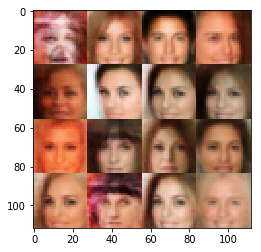

Epoch 1/1... batch 5610/6331... time/batch...0.33s remaining time...235s Discriminator Loss: 0.3802... Generator Loss: 3.9019
Epoch 1/1... batch 5620/6331... time/batch...0.33s remaining time...231s Discriminator Loss: 0.7368... Generator Loss: 2.1097
Epoch 1/1... batch 5630/6331... time/batch...0.33s remaining time...228s Discriminator Loss: 0.3898... Generator Loss: 3.5472
Epoch 1/1... batch 5640/6331... time/batch...0.33s remaining time...225s Discriminator Loss: 0.3868... Generator Loss: 4.6808
Epoch 1/1... batch 5650/6331... time/batch...0.33s remaining time...222s Discriminator Loss: 0.3802... Generator Loss: 4.2980
Epoch 1/1... batch 5660/6331... time/batch...0.33s remaining time...218s Discriminator Loss: 0.3890... Generator Loss: 4.0883
Epoch 1/1... batch 5670/6331... time/batch...0.33s remaining time...215s Discriminator Loss: 0.4547... Generator Loss: 2.9608
Epoch 1/1... batch 5680/6331... time/batch...0.33s remaining time...212s Discriminator Loss: 0.4123... Generator Loss:

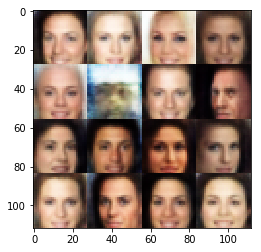

Epoch 1/1... batch 5710/6331... time/batch...0.33s remaining time...202s Discriminator Loss: 0.3848... Generator Loss: 3.7309
Epoch 1/1... batch 5720/6331... time/batch...0.33s remaining time...199s Discriminator Loss: 0.4629... Generator Loss: 3.3415
Epoch 1/1... batch 5730/6331... time/batch...0.33s remaining time...196s Discriminator Loss: 0.9395... Generator Loss: 1.2693
Epoch 1/1... batch 5740/6331... time/batch...0.33s remaining time...192s Discriminator Loss: 0.6479... Generator Loss: 1.8914
Epoch 1/1... batch 5750/6331... time/batch...0.33s remaining time...189s Discriminator Loss: 0.4011... Generator Loss: 3.2530
Epoch 1/1... batch 5760/6331... time/batch...0.33s remaining time...186s Discriminator Loss: 0.4222... Generator Loss: 2.7875
Epoch 1/1... batch 5770/6331... time/batch...0.33s remaining time...182s Discriminator Loss: 0.4915... Generator Loss: 3.6272
Epoch 1/1... batch 5780/6331... time/batch...0.33s remaining time...179s Discriminator Loss: 0.4922... Generator Loss:

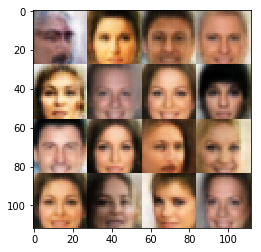

Epoch 1/1... batch 5810/6331... time/batch...0.33s remaining time...169s Discriminator Loss: 0.6529... Generator Loss: 2.3035
Epoch 1/1... batch 5820/6331... time/batch...0.33s remaining time...166s Discriminator Loss: 0.6446... Generator Loss: 2.1431
Epoch 1/1... batch 5830/6331... time/batch...0.33s remaining time...163s Discriminator Loss: 0.4217... Generator Loss: 3.9299
Epoch 1/1... batch 5840/6331... time/batch...0.33s remaining time...160s Discriminator Loss: 0.3760... Generator Loss: 3.5127
Epoch 1/1... batch 5850/6331... time/batch...0.33s remaining time...156s Discriminator Loss: 0.4345... Generator Loss: 3.7598
Epoch 1/1... batch 5860/6331... time/batch...0.33s remaining time...153s Discriminator Loss: 0.4170... Generator Loss: 4.0835
Epoch 1/1... batch 5870/6331... time/batch...0.33s remaining time...150s Discriminator Loss: 1.3874... Generator Loss: 1.0657
Epoch 1/1... batch 5880/6331... time/batch...0.33s remaining time...147s Discriminator Loss: 0.4798... Generator Loss:

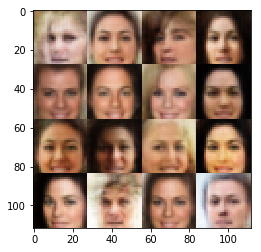

Epoch 1/1... batch 5910/6331... time/batch...0.33s remaining time...137s Discriminator Loss: 0.3731... Generator Loss: 2.8878
Epoch 1/1... batch 5920/6331... time/batch...0.33s remaining time...134s Discriminator Loss: 0.6179... Generator Loss: 1.9095
Epoch 1/1... batch 5930/6331... time/batch...0.33s remaining time...130s Discriminator Loss: 0.4071... Generator Loss: 3.2318
Epoch 1/1... batch 5940/6331... time/batch...0.33s remaining time...127s Discriminator Loss: 0.4187... Generator Loss: 3.3630
Epoch 1/1... batch 5950/6331... time/batch...0.33s remaining time...124s Discriminator Loss: 0.4075... Generator Loss: 3.8531
Epoch 1/1... batch 5960/6331... time/batch...0.33s remaining time...120s Discriminator Loss: 0.4157... Generator Loss: 3.9615
Epoch 1/1... batch 5970/6331... time/batch...0.33s remaining time...117s Discriminator Loss: 0.5739... Generator Loss: 2.0666
Epoch 1/1... batch 5980/6331... time/batch...0.33s remaining time...114s Discriminator Loss: 0.9480... Generator Loss:

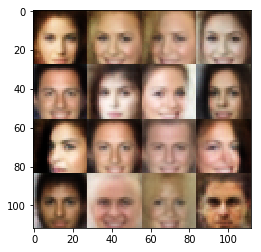

Epoch 1/1... batch 6010/6331... time/batch...0.33s remaining time...104s Discriminator Loss: 1.6932... Generator Loss: 5.9520
Epoch 1/1... batch 6020/6331... time/batch...0.33s remaining time...101s Discriminator Loss: 0.3724... Generator Loss: 3.3068
Epoch 1/1... batch 6030/6331... time/batch...0.33s remaining time...98s Discriminator Loss: 0.4710... Generator Loss: 3.1432
Epoch 1/1... batch 6040/6331... time/batch...0.33s remaining time...94s Discriminator Loss: 0.3818... Generator Loss: 3.6103
Epoch 1/1... batch 6050/6331... time/batch...0.33s remaining time...91s Discriminator Loss: 0.4046... Generator Loss: 3.4235
Epoch 1/1... batch 6060/6331... time/batch...0.33s remaining time...88s Discriminator Loss: 0.4130... Generator Loss: 4.5594
Epoch 1/1... batch 6070/6331... time/batch...0.33s remaining time...85s Discriminator Loss: 0.3660... Generator Loss: 3.0088
Epoch 1/1... batch 6080/6331... time/batch...0.33s remaining time...81s Discriminator Loss: 0.4801... Generator Loss: 3.401

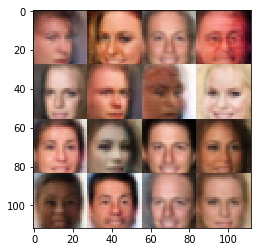

Epoch 1/1... batch 6110/6331... time/batch...0.33s remaining time...72s Discriminator Loss: 0.5132... Generator Loss: 3.6519
Epoch 1/1... batch 6120/6331... time/batch...0.33s remaining time...68s Discriminator Loss: 0.3525... Generator Loss: 4.0901
Epoch 1/1... batch 6130/6331... time/batch...0.33s remaining time...65s Discriminator Loss: 0.4436... Generator Loss: 3.6751
Epoch 1/1... batch 6140/6331... time/batch...0.33s remaining time...62s Discriminator Loss: 0.8831... Generator Loss: 2.0264
Epoch 1/1... batch 6150/6331... time/batch...0.33s remaining time...59s Discriminator Loss: 0.3792... Generator Loss: 4.6000
Epoch 1/1... batch 6160/6331... time/batch...0.33s remaining time...55s Discriminator Loss: 0.3804... Generator Loss: 4.0054
Epoch 1/1... batch 6170/6331... time/batch...0.33s remaining time...52s Discriminator Loss: 0.4972... Generator Loss: 2.6608
Epoch 1/1... batch 6180/6331... time/batch...0.33s remaining time...49s Discriminator Loss: 0.4712... Generator Loss: 2.9510


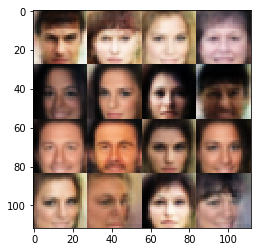

Epoch 1/1... batch 6210/6331... time/batch...0.33s remaining time...39s Discriminator Loss: 0.3869... Generator Loss: 3.9212
Epoch 1/1... batch 6220/6331... time/batch...0.33s remaining time...36s Discriminator Loss: 0.8261... Generator Loss: 4.6275
Epoch 1/1... batch 6230/6331... time/batch...0.33s remaining time...32s Discriminator Loss: 0.3660... Generator Loss: 4.9635
Epoch 1/1... batch 6240/6331... time/batch...0.33s remaining time...29s Discriminator Loss: 0.3701... Generator Loss: 3.9374
Epoch 1/1... batch 6250/6331... time/batch...0.33s remaining time...26s Discriminator Loss: 0.4076... Generator Loss: 3.4803
Epoch 1/1... batch 6260/6331... time/batch...0.33s remaining time...23s Discriminator Loss: 0.4286... Generator Loss: 3.4301
Epoch 1/1... batch 6270/6331... time/batch...0.33s remaining time...19s Discriminator Loss: 0.4332... Generator Loss: 3.4953
Epoch 1/1... batch 6280/6331... time/batch...0.33s remaining time...16s Discriminator Loss: 0.4546... Generator Loss: 3.2217


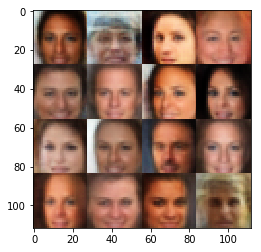

Epoch 1/1... batch 6310/6331... time/batch...0.33s remaining time...6s Discriminator Loss: 0.3918... Generator Loss: 4.5937
Epoch 1/1... batch 6320/6331... time/batch...0.33s remaining time...3s Discriminator Loss: 0.4208... Generator Loss: 2.6206
Epoch 1/1... batch 6330/6331... time/batch...0.33s remaining time...0s Discriminator Loss: 0.4234... Generator Loss: 2.9365


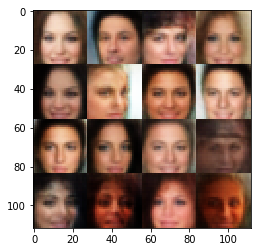

In [102]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, _ = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

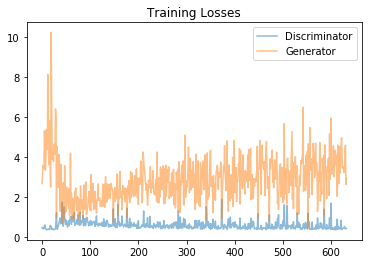

In [103]:
plot_losses(losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.